### Dataset preparation / downloading from Kaggle

In [1]:
# Install the Kaggle Python package
!pip install kaggle

In [2]:
# Create a directory named .kaggle for the kaggle.json file
!mkdir -p /home/adam/.kaggle/

In [3]:
# Set appropriate permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Move the kaggle.json file to the .kaggle directory
!mv ~/Pobrane/kaggle.json ~/.kaggle/kaggle.json

mv: nie można wykonać stat na '/home/adam/Pobrane/kaggle.json': Nie ma takiego pliku ani katalogu


In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Create an instance of KaggleApi
api = KaggleApi()

# Authenticate using the Kaggle API
api.authenticate()

In [6]:
# Download dataset using Kaggle CLI
!kaggle datasets download -d adityakadiwal/water-potability -p dataset


water-potability.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = 'dataset/water-potability.zip'

# Path to the directory where you want to extract files
extracted_dir = 'data'

# Extract files from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Confirm that the files have been extracted
os.listdir(extracted_dir)

['water_potability.csv']

### Environment preparation

In [8]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score, f1_score, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from itertools import product

### Loading a dataset

In [9]:
# Read the CSV file into a DataFrame
df_init = pd.read_csv('data/water_potability.csv')

# Display the first few rows of the DataFrame
display(df_init.head(2))

# Display the last few rows of the DataFrame
display(df_init.tail(2))

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0      NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.71608  129.422921  18630.057858     6.635246         NaN    592.885359   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0

ph    Hardness        Solids  Chloramines  Sulfate  Conductivity  \
3274  5.126763  230.603758  11983.869376     6.303357      NaN    402.883113   
3275  7.874671  195.102299  17404.177061     7.509306      NaN    327.459760   

      Organic_carbon  Trihalomethanes  Turbidity  Potability  
3274       11.168946        77.488213   4.708658           1  
3275       16.140368        78.698446   2.309149           1

#### Dataset information 

In [10]:
# Create a copy of the DataFrame
df = df_init.copy()

In [11]:
# Converting string columns to lowercase and replacing spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [12]:
# Retrieve the column names of the DataFrame and convert them to a Python list
df.columns.values.tolist()

['ph',
 'hardness',
 'solids',
 'chloramines',
 'sulfate',
 'conductivity',
 'organic_carbon',
 'trihalomethanes',
 'turbidity',
 'potability']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   hardness         3276 non-null   float64
 2   solids           3276 non-null   float64
 3   chloramines      3276 non-null   float64
 4   sulfate          2495 non-null   float64
 5   conductivity     3276 non-null   float64
 6   organic_carbon   3276 non-null   float64
 7   trihalomethanes  3114 non-null   float64
 8   turbidity        3276 non-null   float64
 9   potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [14]:
df.shape

(3276, 10)

In [15]:
df.duplicated().sum()

0

In [16]:
df.describe().T

count          mean          std         min           25%  \
ph               2785.0      7.080795     1.594320    0.000000      6.093092   
hardness         3276.0    196.369496    32.879761   47.432000    176.850538   
solids           3276.0  22014.092526  8768.570828  320.942611  15666.690297   
chloramines      3276.0      7.122277     1.583085    0.352000      6.127421   
sulfate          2495.0    333.775777    41.416840  129.000000    307.699498   
conductivity     3276.0    426.205111    80.824064  181.483754    365.734414   
organic_carbon   3276.0     14.284970     3.308162    2.200000     12.065801   
trihalomethanes  3114.0     66.396293    16.175008    0.738000     55.844536   
turbidity        3276.0      3.966786     0.780382    1.450000      3.439711   
potability       3276.0      0.390110     0.487849    0.000000      0.000000   

                          50%           75%           max  
ph                   7.036752      8.062066     14.000000  
hardness           196.967627    216.667456    323.124000  
solids           20927.833607  27332.762127  61227.196008  
chloramines          7.130299      8.114887     13.127000  
sulfate            333.073546    359.950170    481.030642  
conductivity       421.884968    481.792304    753.342620  
organic_carbon      14.218338     16.557652     28.300000  
trihalomethanes     66.622485     77.337473    124.000000  
turbidity            3.955028      4.500320      6.739000  
potability           0.000000      1.000000      1.000000

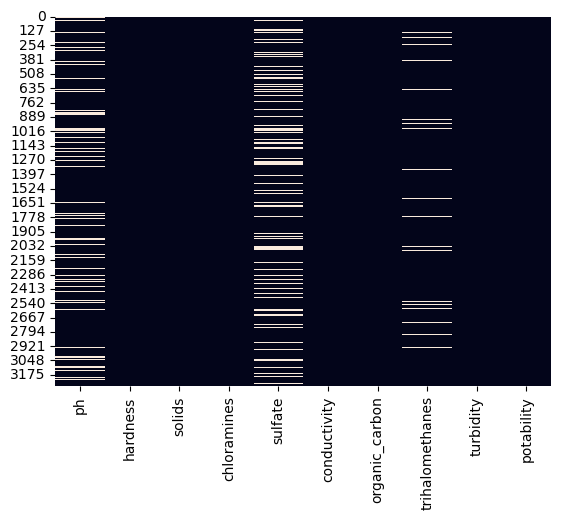

                 Missing Count Missing Percent
ph                         491          14.99%
hardness                     0           0.00%
solids                       0           0.00%
chloramines                  0           0.00%
sulfate                    781          23.84%
conductivity                 0           0.00%
organic_carbon               0           0.00%
trihalomethanes            162           4.95%
turbidity                    0           0.00%
potability                   0           0.00%


In [17]:
def display_missing_data_info(df):
    # Calculate the count of missing data
    missing_count = df.isnull().sum()

    # Calculate the percentage of missing data
    missing_percent = df.isnull().sum() * 100 / len(df)

    # Round the percentage to two decimal places
    percent_missing_rounded = missing_percent.round(2)

    # Format the percentage as strings
    formatted_percent_missing = percent_missing_rounded.apply(lambda x: f"{x:.2f}%")

    # Concatenate the missing count and formatted percentage into a DataFrame
    missing_info = pd.concat([missing_count, formatted_percent_missing], axis=1)
    missing_info.columns = ['Missing Count', 'Missing Percent']

    # Visualization of missing data using a heatmap
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

    # Display the table with the count and percentage of missing data
    print(missing_info)

# Displaying the results
display_missing_data_info(df)

Uzupełnianie danych *ph*

### completing missing data

In [18]:
# Definition of hardness ranges in American units
hardness_ranges = {
    'Very soft': (0, 89),
    'Soft': (89, 179),
    'Medium hardness': (179, 268),
    'Of considerable hardness': (268, 357),
    'Hard': (357, 535),
    'Very hard': (535, float('inf'))
}

# Creating a DataFrame
data = {'American unit CaCO3 mg/l(ppm)': []}

# Populate the DataFrame with range information
for water_type, (lower, upper) in hardness_ranges.items():
    data['American unit CaCO3 mg/l(ppm)'].append(f"{lower} – {upper}")

# Displaying the results
df_hardness_ranges = pd.DataFrame(data, index=hardness_ranges.keys())
print(df_hardness_ranges)


                         American unit CaCO3 mg/l(ppm)
Very soft                                       0 – 89
Soft                                          89 – 179
Medium hardness                              179 – 268
Of considerable hardness                     268 – 357
Hard                                         357 – 535
Very hard                                    535 – inf


In [19]:
# Definition of the function fill_missing_data_ph
def fill_missing_data_ph(df):
    # Create df_mean_fill as a copy of the original DataFrame
    df_mean_fill = df.copy()

    # Categorize data into 'hardness_threshold' categories
    df_mean_fill['hardness_threshold'] = pd.cut(df_mean_fill['hardness'], bins=[-float('inf'), 89, 179, 269, float('inf')],
                                           labels=['Below 89', '90-179', '180-269', 'Above 268'])

    # Define conditions for data imputation
    condition_1 = (df_mean_fill['hardness_threshold'] == 'Below 89') & (df_mean_fill['potability'] == 0)
    condition_2 = (df_mean_fill['hardness_threshold'] == 'Below 89') & (df_mean_fill['potability'] == 1)
    condition_3 = (df_mean_fill['hardness_threshold'] == '90-179') & (df_mean_fill['potability'] == 0)
    condition_4 = (df_mean_fill['hardness_threshold'] == '90-179') & (df_mean_fill['potability'] == 1)
    condition_5 = (df_mean_fill['hardness_threshold'] == '180-269') & (df_mean_fill['potability'] == 0)
    condition_6 = (df_mean_fill['hardness_threshold'] == '180-269') & (df_mean_fill['potability'] == 1)
    condition_7 = (df_mean_fill['hardness_threshold'] == 'Above 268') & (df_mean_fill['potability'] == 0)
    condition_8 = (df_mean_fill['hardness_threshold'] == 'Above 268') & (df_mean_fill['potability'] == 1)

    # Impute missing data in the 'ph' column based on conditions
    df_mean_fill.loc[condition_1, 'ph'] = df_mean_fill.loc[condition_1, 'ph'].fillna(df_mean_fill.loc[condition_1, 'ph'].mean())
    df_mean_fill.loc[condition_2, 'ph'] = df_mean_fill.loc[condition_2, 'ph'].fillna(df_mean_fill.loc[condition_2, 'ph'].mean())
    df_mean_fill.loc[condition_3, 'ph'] = df_mean_fill.loc[condition_3, 'ph'].fillna(df_mean_fill.loc[condition_3, 'ph'].mean())
    df_mean_fill.loc[condition_4, 'ph'] = df_mean_fill.loc[condition_4, 'ph'].fillna(df_mean_fill.loc[condition_4, 'ph'].mean())
    df_mean_fill.loc[condition_5, 'ph'] = df_mean_fill.loc[condition_5, 'ph'].fillna(df_mean_fill.loc[condition_5, 'ph'].mean())
    df_mean_fill.loc[condition_6, 'ph'] = df_mean_fill.loc[condition_6, 'ph'].fillna(df_mean_fill.loc[condition_6, 'ph'].mean())
    df_mean_fill.loc[condition_7, 'ph'] = df_mean_fill.loc[condition_7, 'ph'].fillna(df_mean_fill.loc[condition_7, 'ph'].mean())
    df_mean_fill.loc[condition_8, 'ph'] = df_mean_fill.loc[condition_8, 'ph'].fillna(df_mean_fill.loc[condition_8, 'ph'].mean())

    return df_mean_fill


In [20]:
# Creating a new dataset with filled data using the mean pH based on water hardness ranges
df_mean = fill_missing_data_ph(df)

In [21]:
# Setting the water hardness threshold
hardness_threshold = 179

# Splitting the data into two categories 'hardness' (below 179 and above 179)
df_mean['hardness_category'] = pd.cut(df_mean['hardness'], bins=[-float('inf'), hardness_threshold, float('inf')],
                                 labels=['Below 179', 'Above 179'])

# Calculating the average pH for each 'hardness' and 'potability' category
average_ph_by_category = df_mean.groupby(['potability', 'hardness_category'])['ph'].mean().unstack()

# Displaying the results
print("Average 'ph' value for each 'hardness' and 'potability' category:")
print(average_ph_by_category)


Average 'ph' value for each 'hardness' and 'potability' category:
hardness_category  Below 179  Above 179
potability                             
0                   6.810854   7.184008
1                   7.039684   7.084732


Uzupełnianie danych *sulfate*

In [22]:
# Defining a function to describe sulfate concentrations based on potability and pH categories
def describe_sulfate_by_potability_and_ph(df):
    # Adding the 'ph_category' column
    df['ph_category'] = np.where(df['ph'] < 7, 'Below 7', '7 and Above')

    # Grouping the data
    grouped_data = df.groupby(['potability', 'ph_category'])['sulfate'].mean().unstack()

    # Adding the mean for each sulfate concentration range
    grouped_data['Mean Sulfate'] = df.groupby('potability')['sulfate'].mean()

    return grouped_data

# Displaying the results
result = describe_sulfate_by_potability_and_ph(df_mean)
print("Average sulfate concentrations for different potability and pH categories, along with overall mean:")
print(result)


Average sulfate concentrations for different potability and pH categories, along with overall mean:
ph_category  7 and Above     Below 7  Mean Sulfate
potability                                        
0             339.747017  328.421520     334.56429
1             325.343724  340.946613     332.56699


In [23]:
# Defining a function to fill missing sulfate values with category-specific means
def fill_missing_sulfate_with_mean(df):
    # Adding the 'ph_category' column
    df['ph_category'] = np.where(df['ph'] < 7, 'Below 7', '7 and Above')

    # Filling missing values in the 'sulfate' column with category-specific means
    df['sulfate'] = df.groupby(['potability', 'ph_category'])['sulfate'].transform(lambda x: x.fillna(x.mean()))

    return df


In [24]:
df_mean = fill_missing_sulfate_with_mean(df_mean)

Data completion *Trihalomethanes*.

In [25]:
# Defining a function to describe trihalomethanes by potability and pH categories
def describe_tmh_by_potability_and_ph(df):
    # Adding the 'trihalomethanes_category' column
    df['trihalomethanes_category'] = np.where(df['ph'] < 7, 'Below 7', '7 and Above')

    # Grouping data
    grouped_data = df.groupby(['potability', 'trihalomethanes_category'])['trihalomethanes'].mean().unstack()

    # Adding the mean for each trihalomethanes concentration range
    grouped_data['Mean Trihalomethanes'] = df.groupby('potability')['trihalomethanes'].mean()

    return grouped_data

# Example usage of the function
result = describe_tmh_by_potability_and_ph(df_mean)
print("Average Trihalomethanes concentrations for different potability and pH categories, and overall mean:")
print(result)


Average Trihalomethanes concentrations for different potability and pH categories, and overall mean:
trihalomethanes_category  7 and Above    Below 7  Mean Trihalomethanes
potability                                                            
0                           66.320090  66.283562             66.303555
1                           66.775596  66.270305             66.539684


In [26]:
# Defining a function to fill missing trihalomethanes values with means based on categories
def fill_missing_tmh_with_mean(df):
    # Adding the 'ph_category' column
    df['ph_category'] = np.where(df['ph'] < 7, 'Below 7', '7 and Above')

    # Filling missing values in the 'trihalomethanes' column with means for each category
    df['trihalomethanes'] = df.groupby(['potability', 'ph_category'])['trihalomethanes'].transform(lambda x: x.fillna(x.mean()))

    return df


In [27]:
df_mean = fill_missing_tmh_with_mean(df_mean)

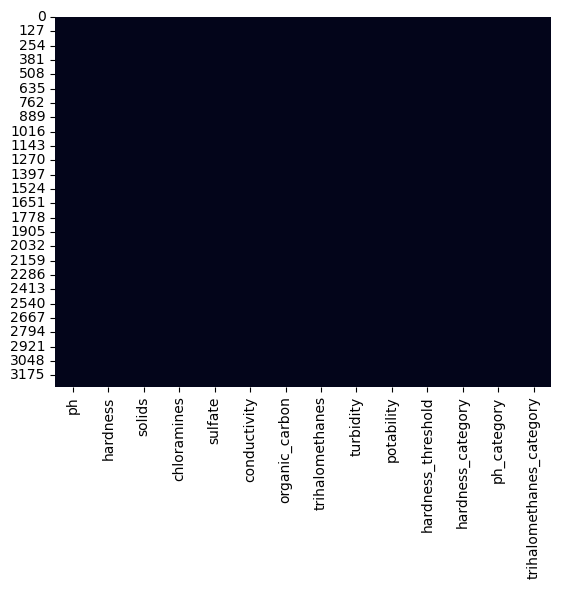

                          Missing Count Missing Percent
ph                                    0           0.00%
hardness                              0           0.00%
solids                                0           0.00%
chloramines                           0           0.00%
sulfate                               0           0.00%
conductivity                          0           0.00%
organic_carbon                        0           0.00%
trihalomethanes                       0           0.00%
turbidity                             0           0.00%
potability                            0           0.00%
hardness_threshold                    0           0.00%
hardness_category                     0           0.00%
ph_category                           0           0.00%
trihalomethanes_category              0           0.00%


In [28]:
def display_missing_data_info(df):
    # Calculate the count of missing data
    missing_count = df.isnull().sum()

    # Calculate the percentage of missing data
    missing_percent = df.isnull().sum() * 100 / len(df)

    # Round the percentage to two decimal places
    percent_missing_rounded = missing_percent.round(2)

    # Format the percentage as strings
    formatted_percent_missing = percent_missing_rounded.apply(lambda x: f"{x:.2f}%")

    # Concatenate the missing count and formatted percentage into a DataFrame
    missing_info = pd.concat([missing_count, formatted_percent_missing], axis=1)
    missing_info.columns = ['Missing Count', 'Missing Percent']

    # Visualization of missing data using a heatmap
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

    # Display the table with the count and percentage of missing data
    print(missing_info)

# Displaying the results
display_missing_data_info(df_mean)

In [29]:
df = df_mean.copy()

In [30]:
# Display summary statistics for the cleaned DataFrame
df.describe().T

count          mean          std         min           25%  \
ph               3276.0      7.080533     1.471398    0.000000      6.277673   
hardness         3276.0    196.369496    32.879761   47.432000    176.850538   
solids           3276.0  22014.092526  8768.570828  320.942611  15666.690297   
chloramines      3276.0      7.122277     1.583085    0.352000      6.127421   
sulfate          3276.0    333.854525    36.285680  129.000000    317.094638   
conductivity     3276.0    426.205111    80.824064  181.483754    365.734414   
organic_carbon   3276.0     14.284970     3.308162    2.200000     12.065801   
trihalomethanes  3276.0     66.395484    15.769934    0.738000     56.647656   
turbidity        3276.0      3.966786     0.780382    1.450000      3.439711   
potability       3276.0      0.390110     0.487849    0.000000      0.000000   

                          50%           75%           max  
ph                   7.116613      7.873622     14.000000  
hardness           196.967627    216.667456    323.124000  
solids           20927.833607  27332.762127  61227.196008  
chloramines          7.130299      8.114887     13.127000  
sulfate            333.875416    350.385756    481.030642  
conductivity       421.884968    481.792304    753.342620  
organic_carbon      14.218338     16.557652     28.300000  
trihalomethanes     66.320090     76.666609    124.000000  
turbidity            3.955028      4.500320      6.739000  
potability           0.000000      1.000000      1.000000

In [31]:
# Function to display covariance for numeric columns only
def display_numeric_covariance(df, title):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['int64', 'float64'])

    # Check if there are numeric columns for analysis
    if numeric_df.shape[1] == 0:
        print("No numeric columns for analysis.")
        return

    # Calculate covariance only for numeric columns
    covariance_matrix = numeric_df.cov()

    # Styling and displaying the results
    styled_matrix = covariance_matrix.style.background_gradient(cmap="Blues")
    print(f"Covariance: {title}")
    print(f"Shape: {numeric_df.shape}")
    display(styled_matrix)


display_numeric_covariance(df, "df")


Covariance: df
Shape: (3276, 10)


In [32]:
# Function to display correlation for numeric columns only
def display_numeric_correlation(df, title):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['int64', 'float64'])

    # Check if there are numeric columns for analysis
    if numeric_df.shape[1] == 0:
        print("No numeric columns for analysis.")
        return

    # Calculate correlation only for numeric columns
    correlation_matrix = numeric_df.corr()

    # Styling and displaying the results
    styled_matrix = correlation_matrix.style.background_gradient(cmap="Blues")
    print(f"Correlation: {title}")
    print(f"Shape: {numeric_df.shape}")
    display(styled_matrix)

# Example of using the function for different DataFrame
display_numeric_correlation(df, "df")


Correlation: df
Shape: (3276, 10)


In [33]:
df.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity', 'potability',
       'hardness_threshold', 'hardness_category', 'ph_category',
       'trihalomethanes_category'],
      dtype='object')

In [34]:
# selected_columns = ['ph_category', 'trihalomethanes_category']  # Replace with your actual column names
# df[selected_columns] = df[selected_columns].apply(pd.to_numeric, errors='coerce')

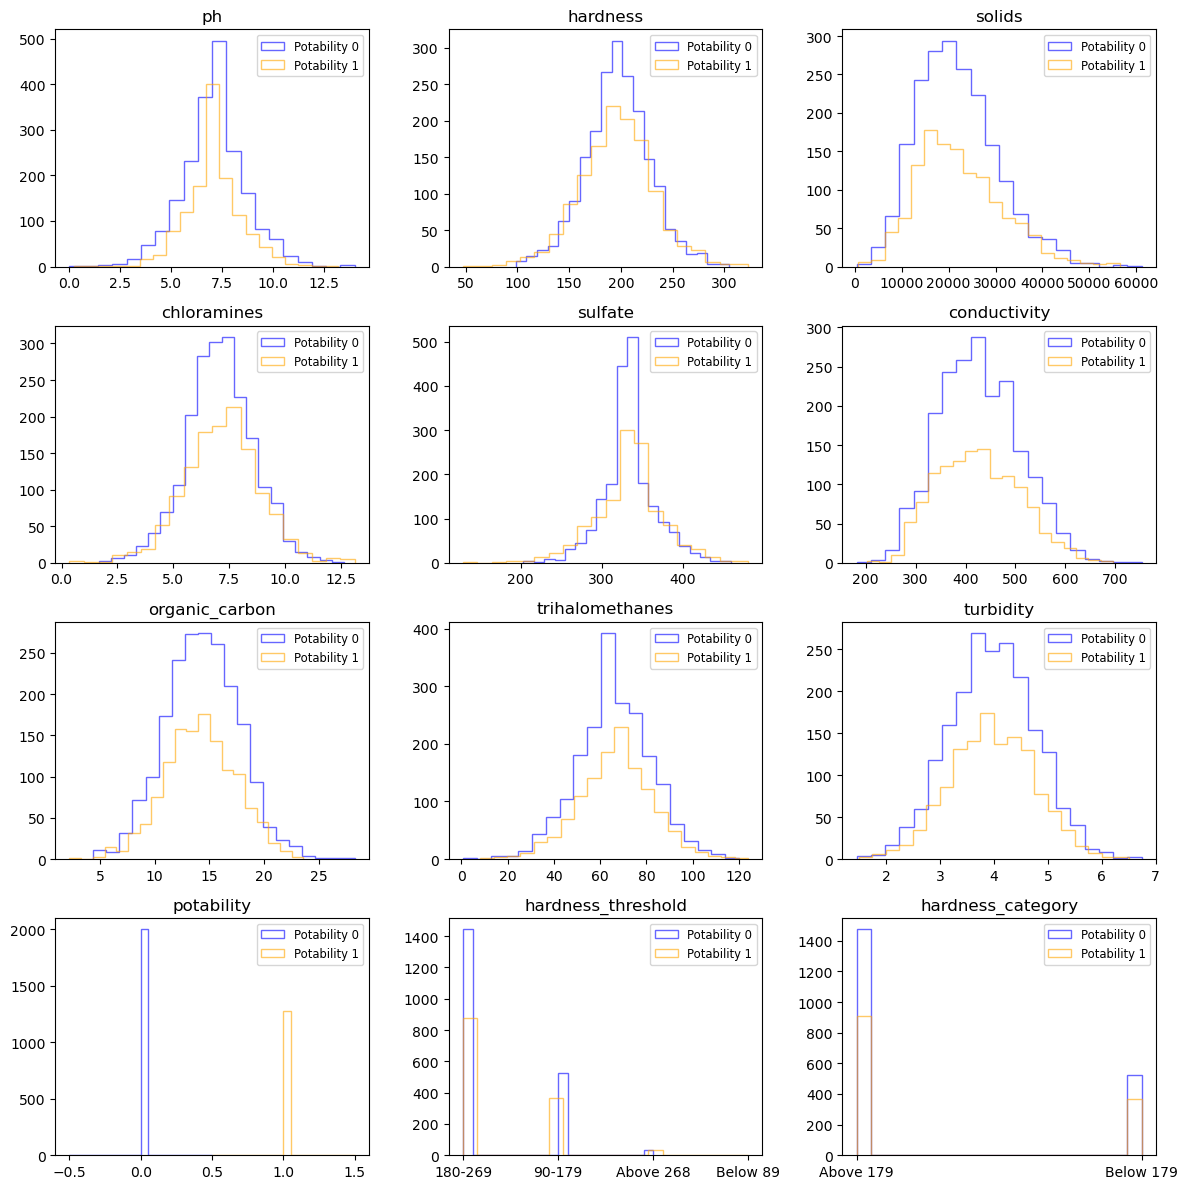

In [35]:
def display_individual_histograms(df, num_cols_per_row=3, figsize=(12, 12), colors=None, alpha=None):
    num_cols = df.select_dtypes(include=['int64', 'float64', 'object']).shape[1]
    num_rows = (num_cols + num_cols_per_row - 1) // num_cols_per_row

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=figsize)

    for i, column in enumerate(df.columns[:-1]):
        row, col = divmod(i, num_cols_per_row)

        for potability, color in zip([0, 1], colors):
            subset = df[df['potability'] == potability]

            if i < num_cols:
                axs[row, col].hist(subset[column], bins=20, edgecolor=color, alpha=alpha, label=f'Potability {potability}', histtype="step")
                axs[row, col].set_title(f'{column}')
                axs[row, col].grid(False)
                axs[row, col].legend(fontsize='small', markerscale=0.4)

    plt.tight_layout()
    plt.show()

# Przykładowe użycie:
display_individual_histograms(df, colors=['blue', 'orange'], alpha=0.6)


In [36]:
# Columns to drop from the DataFrame
columns_to_drop = ['hardness_category', 'hardness_threshold', 'ph_category', 'trihalomethanes_category']

# Drop specified columns
df = df.drop(columns=columns_to_drop)

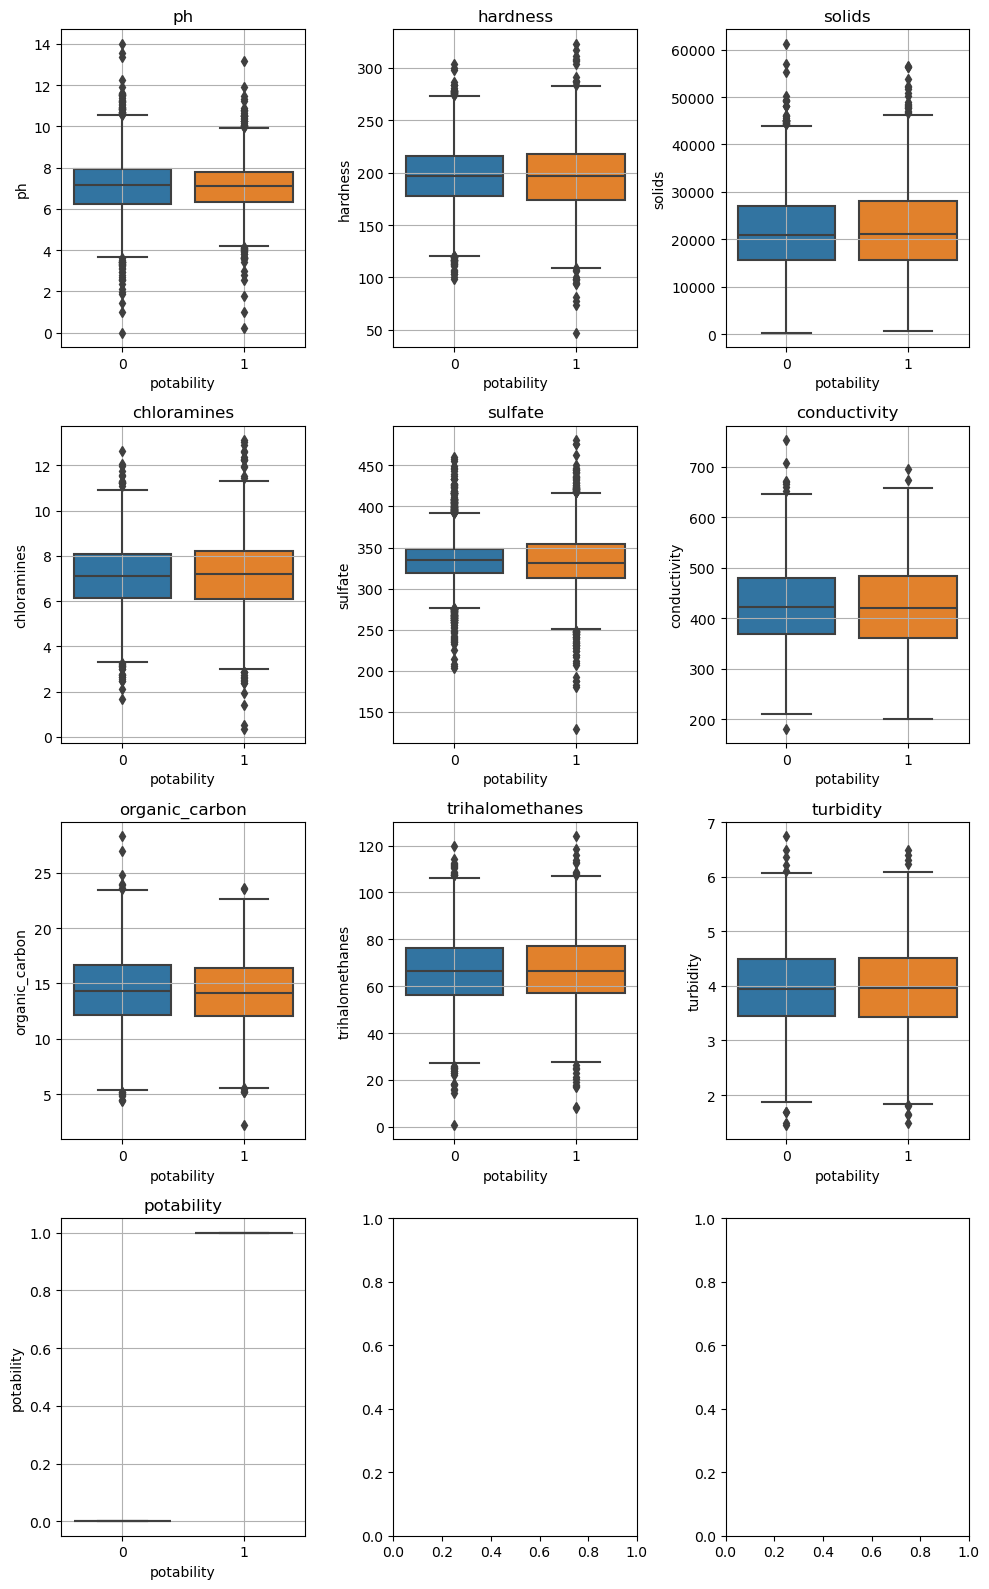

In [37]:
# Function to display boxplots for specified columns with respect to 'potability'
def display_boxplots(df, columns_to_analyze, num_cols_per_row=3, figsize=(10, 4)):
    # Layout settings for subplots
    num_cols = len(columns_to_analyze)
    num_rows = (num_cols + num_cols_per_row - 1) // num_cols_per_row
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(figsize[0], figsize[1] * num_rows))
    fig.subplots_adjust(hspace=0.5)

    # Display boxplots for each column with respect to 'potability'
    for i, column in enumerate(columns_to_analyze):
        row, col = divmod(i, num_cols_per_row)
        sns.boxplot(data=df, x='potability', y=column, ax=axs[row, col])
        axs[row, col].set_title(f'{column}')
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()

display_boxplots(df, columns_to_analyze=df.columns)


In [38]:
# Function to count outliers in each column with respect to 'potability'
def count_outliers_by_potability(df, multiplier=1.5):
    # Create a DataFrame to count outlier values
    outliers_count = pd.DataFrame(index=['potability_0', 'potability_1'], columns=df.columns)
    outliers_count = outliers_count.fillna(0)

    # Iterate through columns
    for column in df.columns:
        # Iterate through potability values (0 and 1)
        for potability_value in [0, 1]:
            # Select data for the specific column and potability value
            subset = df[df['potability'] == potability_value][column]

            # Calculate outlier boundaries
            Q1 = subset.quantile(0.25)
            Q3 = subset.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            # Count outliers
            outliers_count.loc[f'potability_{potability_value}', column] = ((subset < lower_bound) | (subset > upper_bound)).sum()

    return outliers_count

# Displaying the results
outliers_count = count_outliers_by_potability(df)
print("Number of outliers in each column with respect to potability:")
print(outliers_count)


Number of outliers in each column with respect to potability:
              ph  hardness  solids  chloramines  sulfate  conductivity  \
potability_0  66        51      29           31      175             8   
potability_1  55        26      19           27       83             2   

              organic_carbon  trihalomethanes  turbidity  potability  
potability_0              16               31          9           0  
potability_1               8               22          9           0  


In [39]:
# Set threshold conditions for all columns
lower_bounds = df.quantile(0.25) - 1.5 * (df.quantile(0.75) - df.quantile(0.25))
upper_bounds = df.quantile(0.75) + 1.5 * (df.quantile(0.75) - df.quantile(0.25))

# Apply threshold conditions to each column
condition = ((df >= lower_bounds) & (df <= upper_bounds)).all(axis=1)

# Remove rows that do not meet the threshold conditions
df_cleaned = df[condition]

# Display summary statistics for the cleaned DataFrame
df_cleaned.describe().T

count          mean          std         min           25%  \
ph               2666.0      7.073893     1.216507    3.902476      6.348026   
hardness         2666.0    197.051982    28.366547  118.988579    179.010144   
solids           2666.0  21486.829049  7924.092724  320.942611  15596.765222   
chloramines      2666.0      7.111191     1.413403    3.194969      6.188575   
sulfate          2666.0    333.827894    26.715210  267.202392    319.481628   
conductivity     2666.0    425.811207    79.988085  201.619737    365.641745   
organic_carbon   2666.0     14.305441     3.217070    5.362371     12.082883   
trihalomethanes  2666.0     66.437090    14.898620   27.559355     56.915951   
turbidity        2666.0      3.961669     0.760980    1.872573      3.439135   
potability       2666.0      0.373218     0.483750    0.000000      0.000000   

                          50%           75%           max  
ph                   7.116613      7.792306     10.252816  
hardness           197.561474    215.744047    275.886513  
solids           20583.142637  26742.195037  44652.363872  
chloramines          7.114169      8.053054     11.086526  
sulfate            334.045574    347.921235    400.274579  
conductivity       421.320293    481.446065    652.537592  
organic_carbon      14.219418     16.575501     23.234326  
trihalomethanes     66.320090     76.628761    106.371720  
turbidity            3.945844      4.494523      6.083772  
potability           0.000000      1.000000      1.000000

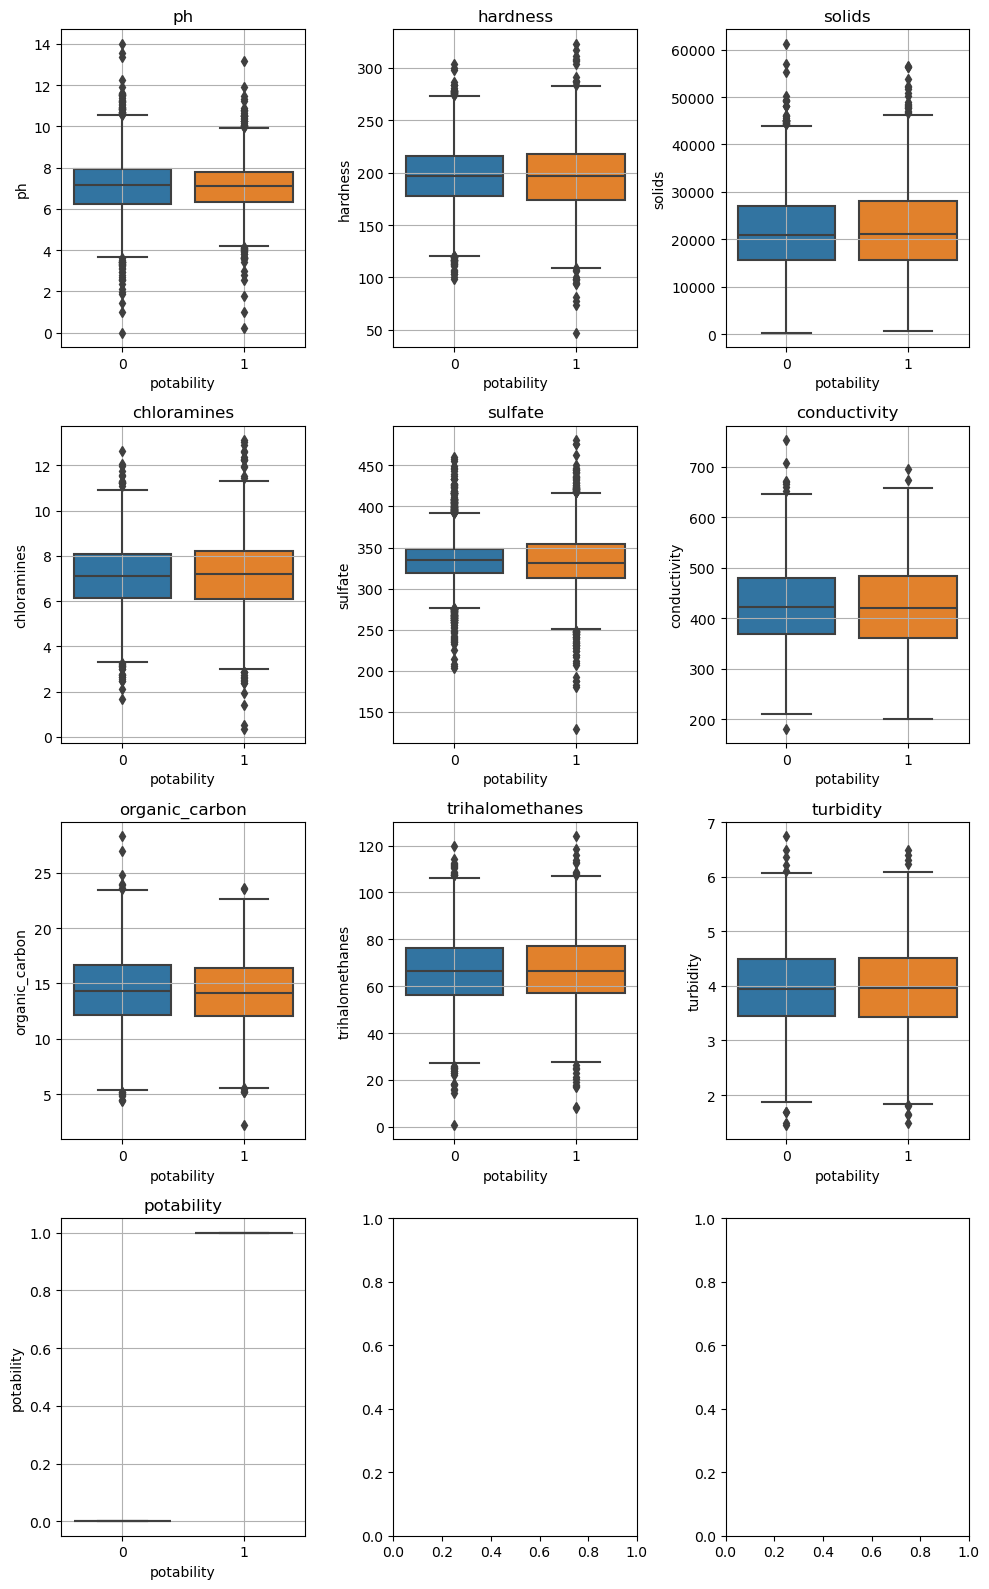

In [40]:
# Function to display boxplots for specified columns with respect to 'potability'
def display_boxplots(df, columns_to_analyze, num_cols_per_row=3, figsize=(10, 4)):
    # Layout settings for subplots
    num_cols = len(columns_to_analyze)
    num_rows = (num_cols + num_cols_per_row - 1) // num_cols_per_row
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(figsize[0], figsize[1] * num_rows))
    fig.subplots_adjust(hspace=0.5)

    # Display boxplots for each column with respect to 'potability'
    for i, column in enumerate(columns_to_analyze):
        row, col = divmod(i, num_cols_per_row)
        sns.boxplot(data=df, x='potability', y=column, ax=axs[row, col])
        axs[row, col].set_title(f'{column}')
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()

display_boxplots(df, columns_to_analyze=df.columns)


In [41]:
# Function to count outliers by potability
def count_outliers_by_potability(df, multiplier=1.5):
    # Create a DataFrame to count outlier values
    outliers_count = pd.DataFrame(index=['potability_0', 'potability_1'], columns=df.columns)
    outliers_count = outliers_count.fillna(0)

    # Iterate through columns
    for column in df.columns:
        # Iterate through potability values (0 and 1)
        for potability_value in [0, 1]:
            # Select data for the specific column and potability value
            subset = df[df['potability'] == potability_value][column]

            # Calculate outlier bounds
            Q1 = subset.quantile(0.25)
            Q3 = subset.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            # Count outliers
            outliers_count.loc[f'potability_{potability_value}', column] = ((subset < lower_bound) | (subset > upper_bound)).sum()

    return outliers_count

outliers_count = count_outliers_by_potability(df_cleaned)
print("Number of outliers in each column with potability breakdown:")
print(outliers_count)


Number of outliers in each column with potability breakdown:
              ph  hardness  solids  chloramines  sulfate  conductivity  \
potability_0  11        17       7           10       99             1   
potability_1  30         4       1            4       10             0   

              organic_carbon  trihalomethanes  turbidity  potability  
potability_0               1                0          2           0  
potability_1               0                0          0           0  


# Data split

In [42]:
# Function to split data into training, validation, and test sets
def split_data(df, df_cleaned, test_size=0.2, random_state=42):
    # Split df into full training and test sets
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Further split the full training set into training and validation sets
    df_train, df_val = train_test_split(df_full_train, test_size=test_size/(1-test_size), random_state=random_state)
    
    # Prepare training and validation data for df
    X_train = df_train.drop('potability', axis=1)
    y_train = df_train['potability']
    X_val = df_val.drop('potability', axis=1)
    y_val = df_val['potability']
    X_test = df_test.drop('potability', axis=1)
    y_test = df_test['potability']

    
    
    # Split df_cleaned into full training and test sets
    df_cleaned_full_train, df_cleaned_test = train_test_split(df_cleaned, test_size=test_size, random_state=random_state)
    
    # Further split the full training set for df_cleaned into training and validation sets
    df_cleaned_train, df_cleaned_val = train_test_split(df_cleaned_full_train, test_size=test_size/(1-test_size), random_state=random_state)
    
    # Prepare training and validation data for df_cleaned
    X_cleaned_train = df_cleaned_train.drop('potability', axis=1)
    y_cleaned_train = df_cleaned_train['potability']
    X_cleaned_val = df_cleaned_val.drop('potability', axis=1)
    y_cleaned_val = df_cleaned_val['potability']
    X_cleaned_test = df_cleaned_test.drop('potability', axis=1)
    y_cleaned_test = df_cleaned_test['potability']

    # Add these lines before the call to evaluate_and_plot_models
    print("Number of features in X_train:", X_train.shape[1])
    print("Number of features in X_val:", X_val.shape[1])
    
    # Add these lines before the call to evaluate_and_plot_models
    print("Number of features in X_train:", X_cleaned_train.shape[1])
    print("Number of features in X_val:", X_cleaned_val.shape[1])
    
    # Display sizes of different data sets for df
    n = len(df)
    n_full_train = len(df_full_train)
    n_train = len(df_train)
    n_val = len(df_val)
    n_test = len(df_test)

    print(f"Size of the full df data set = \t\t\t{n}")
    print(f"Size of the full training df data set = \t{n_full_train}")
    print(f"Size of the training df data set = \t\t{n_train}\t{(n_train / n) * 100:.0f}%")
    print(f"Size of the validation df data set = \t\t{n_val}\t{(n_val / n) * 100:.0f}%")
    print(f"Size of the test df data set = \t\t\t{n_test}\t{(n_test / n) * 100:.0f}%")
    print(f"Sum check for df:\n(Train + Val + Test) = \t\t\t\t{n_train + n_val + n_test}")
    print("-" * 50)
    
    # Display sizes of different data sets for df_cleaned
    n_cleaned = len(df_cleaned)
    n_cleaned_full_train = len(df_cleaned_full_train)
    n_cleaned_train = len(df_cleaned_train)
    n_cleaned_val = len(df_cleaned_val)
    n_cleaned_test = len(df_cleaned_test)

    print(f"\nSize of the full df_cleaned data set = \t\t\t{n_cleaned}")
    print(f"Size of the full training df_cleaned data set = \t{n_cleaned_full_train}")
    print(f"Size of the training df_cleaned data set = \t\t{n_cleaned_train}\t{(n_cleaned_train / n_cleaned) * 100:.0f}%")
    print(f"Size of the validation df_cleaned data set = \t\t{n_cleaned_val}\t{(n_cleaned_val / n_cleaned) * 100:.0f}%")
    print(f"Size of the test df_cleaned data set = \t\t\t{n_cleaned_test}\t{(n_cleaned_test / n_cleaned) * 100:.0f}%")
    print(f"Sum check for df_cleaned:\n(Train + Val + Test) = \t\t\t\t\t{n_cleaned_train + n_cleaned_val + n_cleaned_test}")
  
    return (X_train, y_train, X_val, y_val, X_test, y_test,
            X_cleaned_train, y_cleaned_train, X_cleaned_val, y_cleaned_val, X_cleaned_test, y_cleaned_test)

# Call the function with training data
(X_train, y_train, X_val, y_val, X_test, y_test,
 X_cleaned_train, y_cleaned_train, X_cleaned_val, y_cleaned_val, X_cleaned_test, y_cleaned_test) = split_data(df, df_cleaned)


Number of features in X_train: 9
Number of features in X_val: 9
Number of features in X_train: 9
Number of features in X_val: 9
Size of the full df data set = 			3276
Size of the full training df data set = 	2620
Size of the training df data set = 		1965	60%
Size of the validation df data set = 		655	20%
Size of the test df data set = 			656	20%
Sum check for df:
(Train + Val + Test) = 				3276
--------------------------------------------------

Size of the full df_cleaned data set = 			2666
Size of the full training df_cleaned data set = 	2132
Size of the training df_cleaned data set = 		1599	60%
Size of the validation df_cleaned data set = 		533	20%
Size of the test df_cleaned data set = 			534	20%
Sum check for df_cleaned:
(Train + Val + Test) = 					2666


# Training models

### Support Vector Machine (SVM) models

Dataset: df
Summary for SVM (C=0.001) on df - Training:
Accuracy: 0.6051
Confusion Matrix:
[[1189    0]
 [ 776    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.75      1189
           1       0.00      0.00      0.00       776

    accuracy                           0.61      1965
   macro avg       0.30      0.50      0.38      1965
weighted avg       0.37      0.61      0.46      1965

Summary for SVM (C=0.001) on df - Testing:
Accuracy: 0.6280
Confusion Matrix:
[[412   0]
 [244   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656



Dataset: df
Summary for SVM (C=0.01) on df - Training:
Accuracy: 0.6051
Confusi

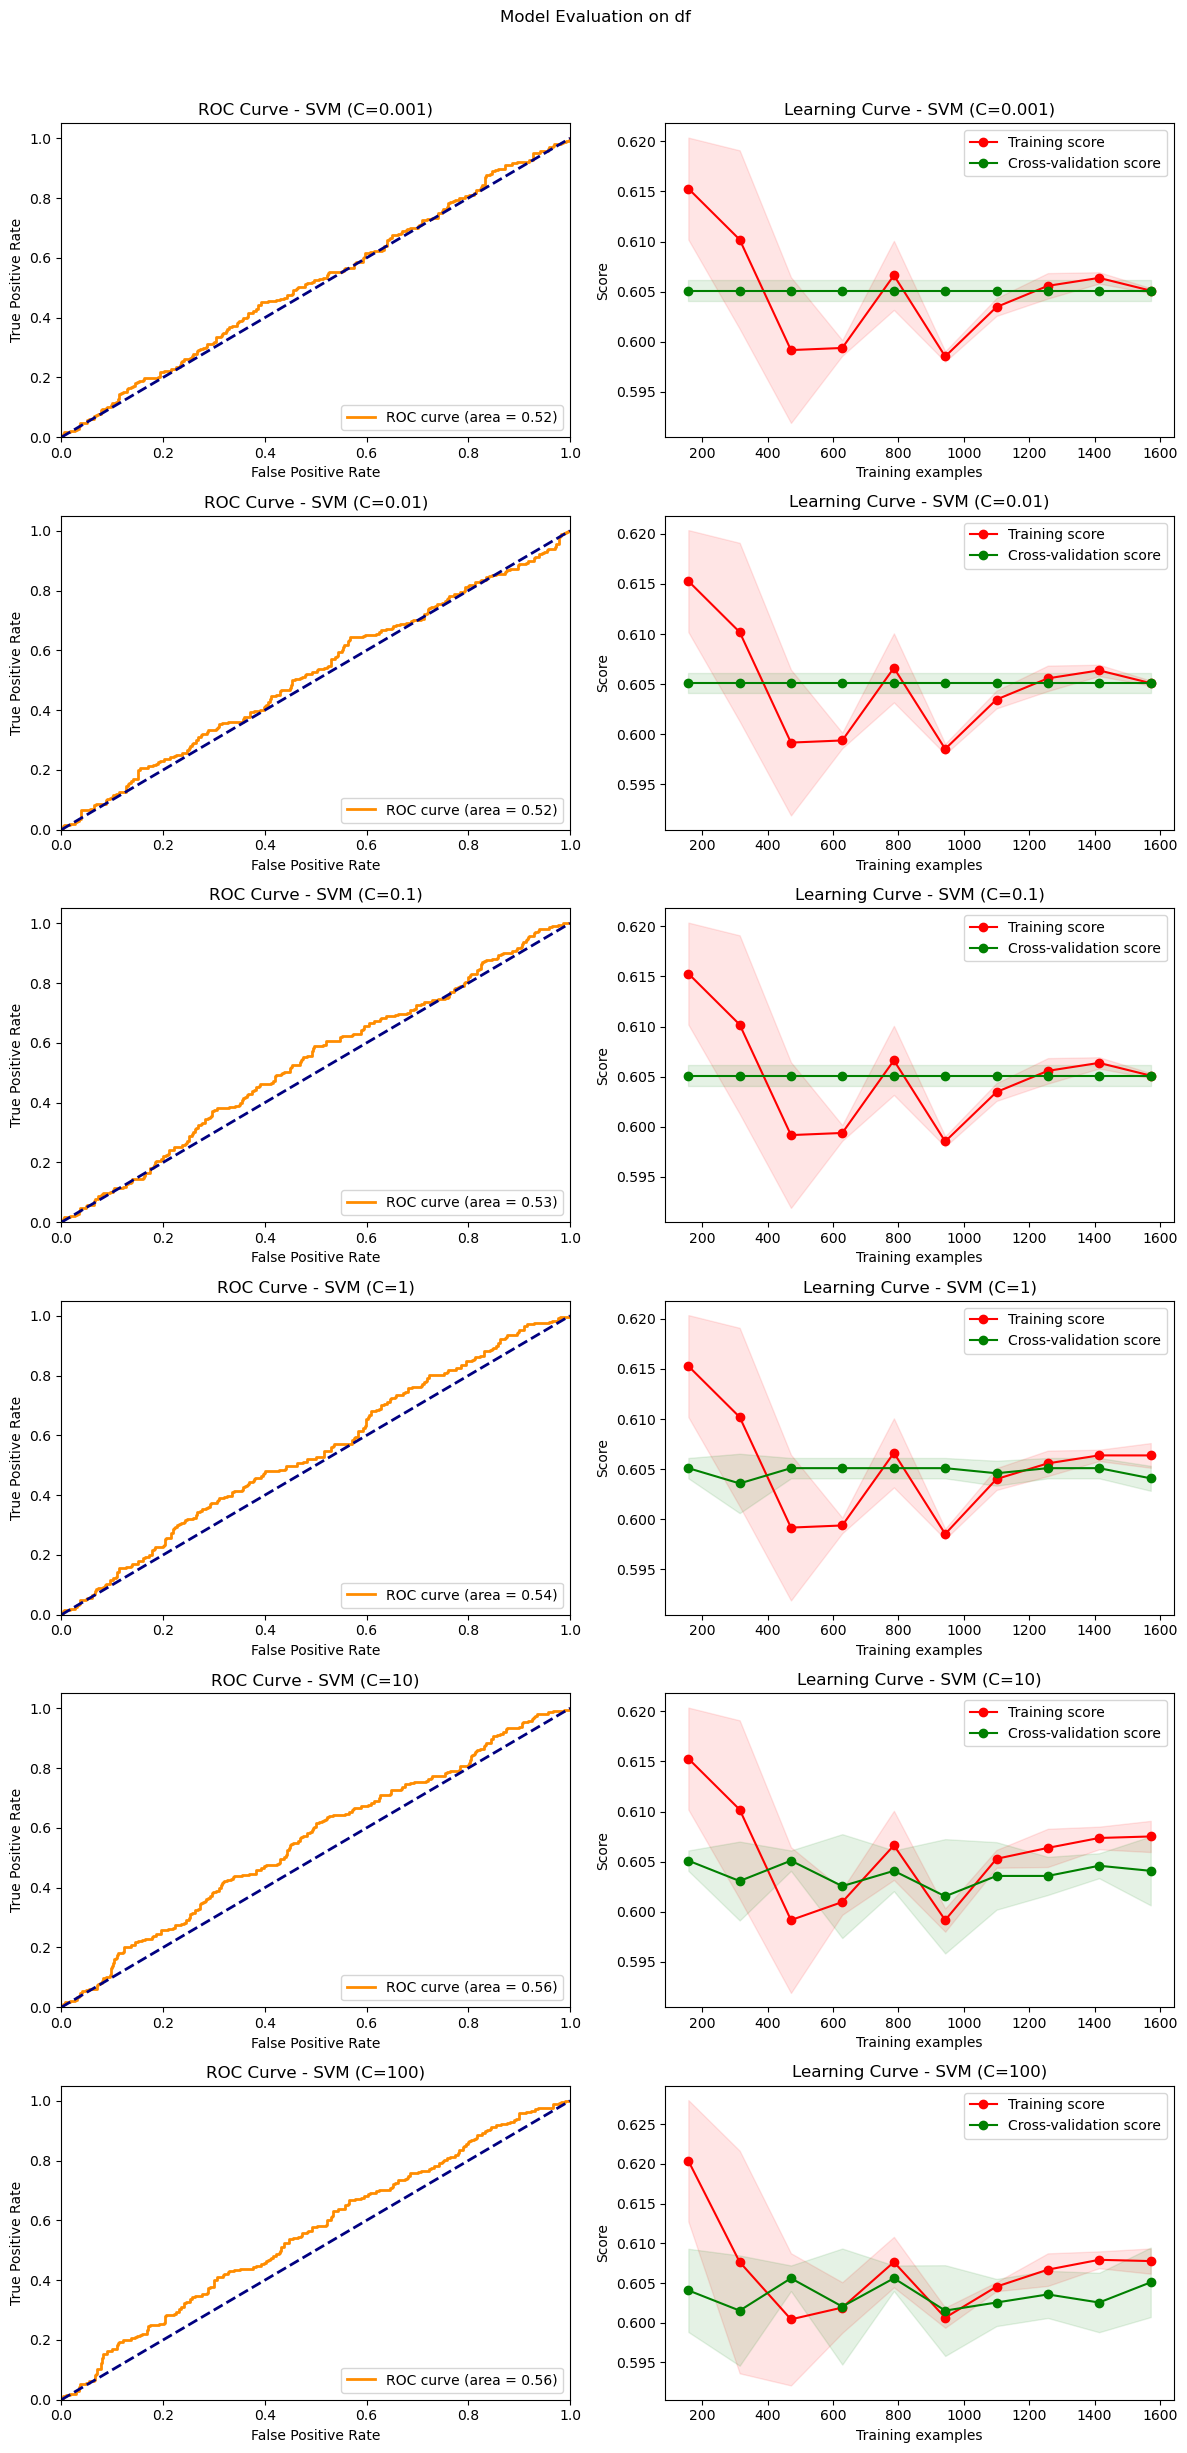

Dataset: df_cleaned
Summary for SVM (C=0.001) on df_cleaned - Training:
Accuracy: 0.6210
Confusion Matrix:
[[993   0]
 [606   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       993
           1       0.00      0.00      0.00       606

    accuracy                           0.62      1599
   macro avg       0.31      0.50      0.38      1599
weighted avg       0.39      0.62      0.48      1599

Summary for SVM (C=0.001) on df_cleaned - Testing:
Accuracy: 0.6404
Confusion Matrix:
[[342   0]
 [192   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       342
           1       0.00      0.00      0.00       192

    accuracy                           0.64       534
   macro avg       0.32      0.50      0.39       534
weighted avg       0.41      0.64      0.50       534



Dataset: df_cleaned
Summary for SVM (C=0.01) on df_cleaned 

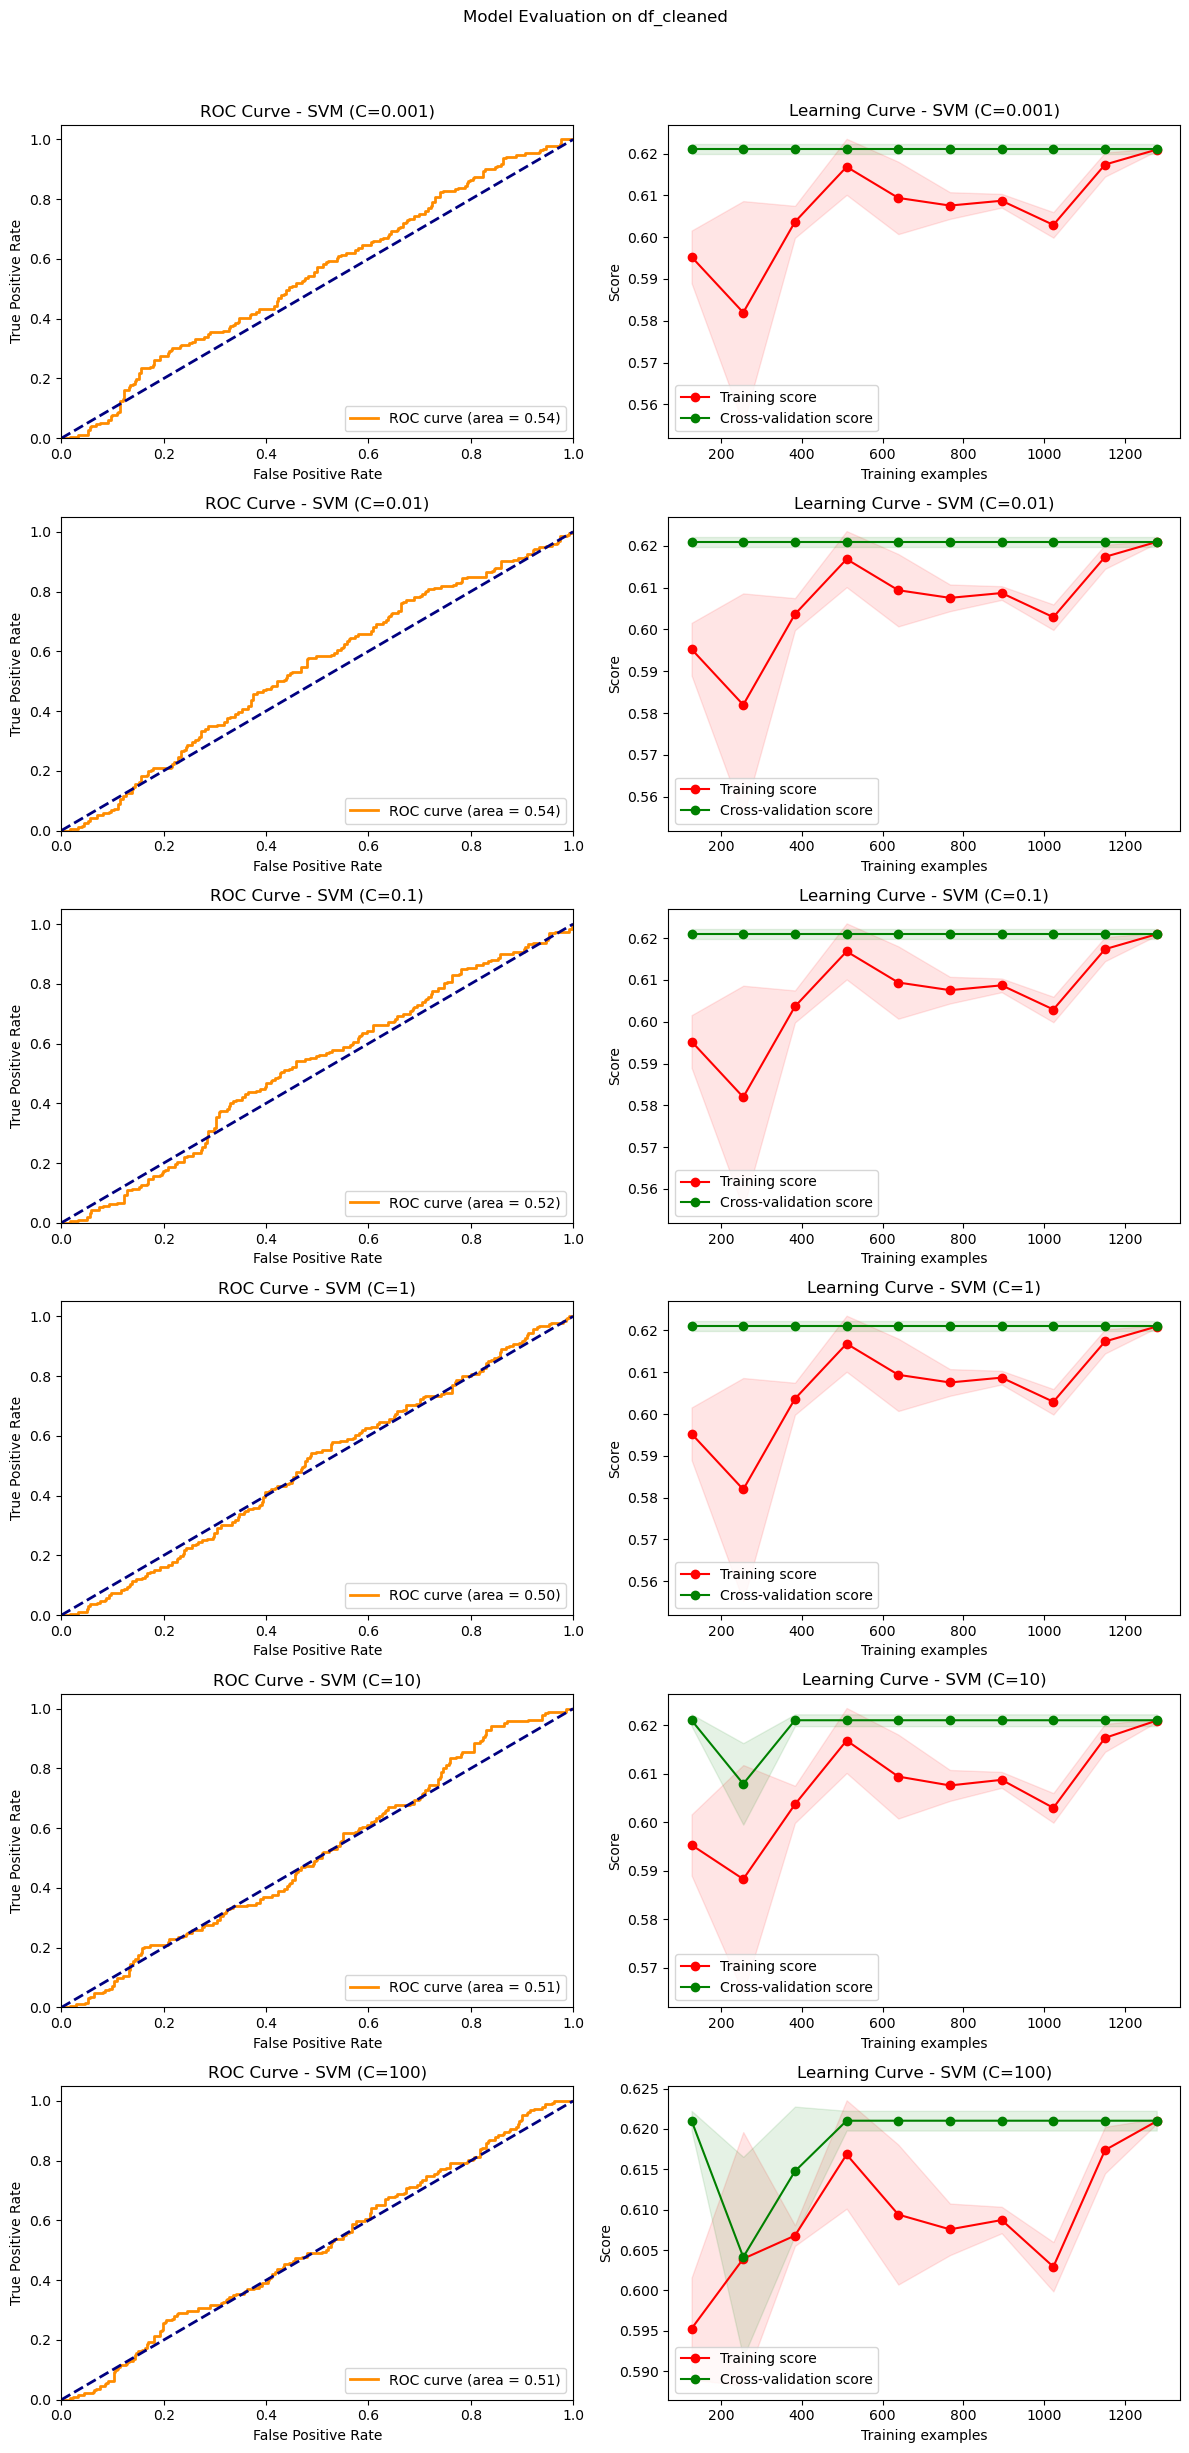

In [43]:
# Function to plot ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, ax, dataset_name):
    model.fit(X_train, y_train)  # Fit the model to the training data
    y_score = model.predict_proba(X_test)[:, 1]  # Predict probabilities on the test set
    fpr, tpr, _ = roc_curve(y_test, y_score)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {dataset_name}')
    ax.legend(loc="lower right")

# Function to plot learning curve for a given model
def plot_learning_curve(model, title, X, y, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.set_title(f"Learning Curve - {title}")
    ax.legend(loc="best")

# Function to generate a summary for a given model
def generate_summary(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, train_predictions)
    accuracy_test = accuracy_score(y_test, test_predictions)

    confusion_mat_train = confusion_matrix(y_train, train_predictions)
    confusion_mat_test = confusion_matrix(y_test, test_predictions)

    classification_rep_train = classification_report(y_train, train_predictions)
    classification_rep_test = classification_report(y_test, test_predictions)

    summary = {
        "Model": model_name,
        "Accuracy_train": accuracy_train,
        "Confusion Matrix_train": confusion_mat_train,
        "Classification Report_train": classification_rep_train,
        "Accuracy_test": accuracy_test,
        "Confusion Matrix_test": confusion_mat_test,
        "Classification Report_test": classification_rep_test,
        "Dataset": dataset_name
    }

    return summary


# Function to evaluate and plot models for a given dataset
def evaluate_and_plot_models(X_train, y_train, X_test, y_test, dataset_name):
    c_values = [0.001, 0.01, 0.1, 1, 10, 100]

    all_summaries = []  # Store summaries for each model

    # Generate summaries for Support Vector Machine (SVM) models
    for c_value in c_values:
        svm_model = SVC(C=c_value, probability=True)  # Include probability=True
        summary = generate_summary(svm_model, X_train, y_train, X_test, y_test, model_name=f"SVM (C={c_value})", dataset_name=dataset_name)
        all_summaries.append(summary)

    # Print summaries
    for summary in all_summaries:
        print(f"Dataset: {summary['Dataset']}")
        print(f"Summary for {summary['Model']} on {summary['Dataset']} - Training:")
        print(f"Accuracy: {summary['Accuracy_train']:.4f}")
        print(f"Confusion Matrix:\n{summary['Confusion Matrix_train']}")
        print(f"Classification Report:\n{summary['Classification Report_train']}")
        print(f"Summary for {summary['Model']} on {summary['Dataset']} - Testing:")
        print(f"Accuracy: {summary['Accuracy_test']:.4f}")
        print(f"Confusion Matrix:\n{summary['Confusion Matrix_test']}")
        print(f"Classification Report:\n{summary['Classification Report_test']}")
        print("\n")

    # Create subplots for ROC Curve and Learning Curve
    fig, axes = plt.subplots(nrows=len(c_values), ncols=2, figsize=(12, 4 * len(c_values)))
    fig.suptitle(f"Model Evaluation on {dataset_name}", y=1.02)

    row_counter = 0

    # Plot ROC Curve and Learning Curve for Support Vector Machine (SVM) models
    for c_value, summary in zip(c_values, all_summaries):
        svm_model = SVC(C=c_value, probability=True)
        plot_roc_curve(svm_model, X_test, y_test, ax=axes[row_counter, 0], dataset_name=f"SVM (C={c_value})")
        plot_learning_curve(svm_model, f"SVM (C={c_value})", X_train, y_train, ax=axes[row_counter, 1])
        row_counter += 1

    plt.tight_layout()
    plt.show()

# For the 'df' dataset
evaluate_and_plot_models(X_train, y_train, X_test, y_test, dataset_name="df")

# For the 'df_cleaned' dataset
evaluate_and_plot_models(X_cleaned_train, y_cleaned_train, X_cleaned_test, y_cleaned_test, dataset_name="df_cleaned")


Observations:It seems like the SVM model with different values of the regularization parameter C (0.001, 0.01, 0.1, 1, 10, 100) is not performing well on both the training and testing sets. The accuracy is around 60-63%, and the confusion matrix and classification report show that the model is not effectively distinguishing between the two classes (0 and 1). The precision, recall, and F1-score for class 1 are consistently low, indicating that the model struggles to correctly identify instances of class 1.

###  K Neighbors Classifier models

Dataset: df
Summary for K Neighbors (3 neighbors) on df - Training:
Accuracy: 0.7700
Confusion Matrix:
[[1020  169]
 [ 283  493]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1189
           1       0.74      0.64      0.69       776

    accuracy                           0.77      1965
   macro avg       0.76      0.75      0.75      1965
weighted avg       0.77      0.77      0.77      1965

Summary for K Neighbors (3 neighbors) on df - Testing:
Accuracy: 0.5396
Confusion Matrix:
[[285 127]
 [175  69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       412
           1       0.35      0.28      0.31       244

    accuracy                           0.54       656
   macro avg       0.49      0.49      0.48       656
weighted avg       0.52      0.54      0.53       656



Dataset: df
Summary for K Neighbors (5 neighbors) on df

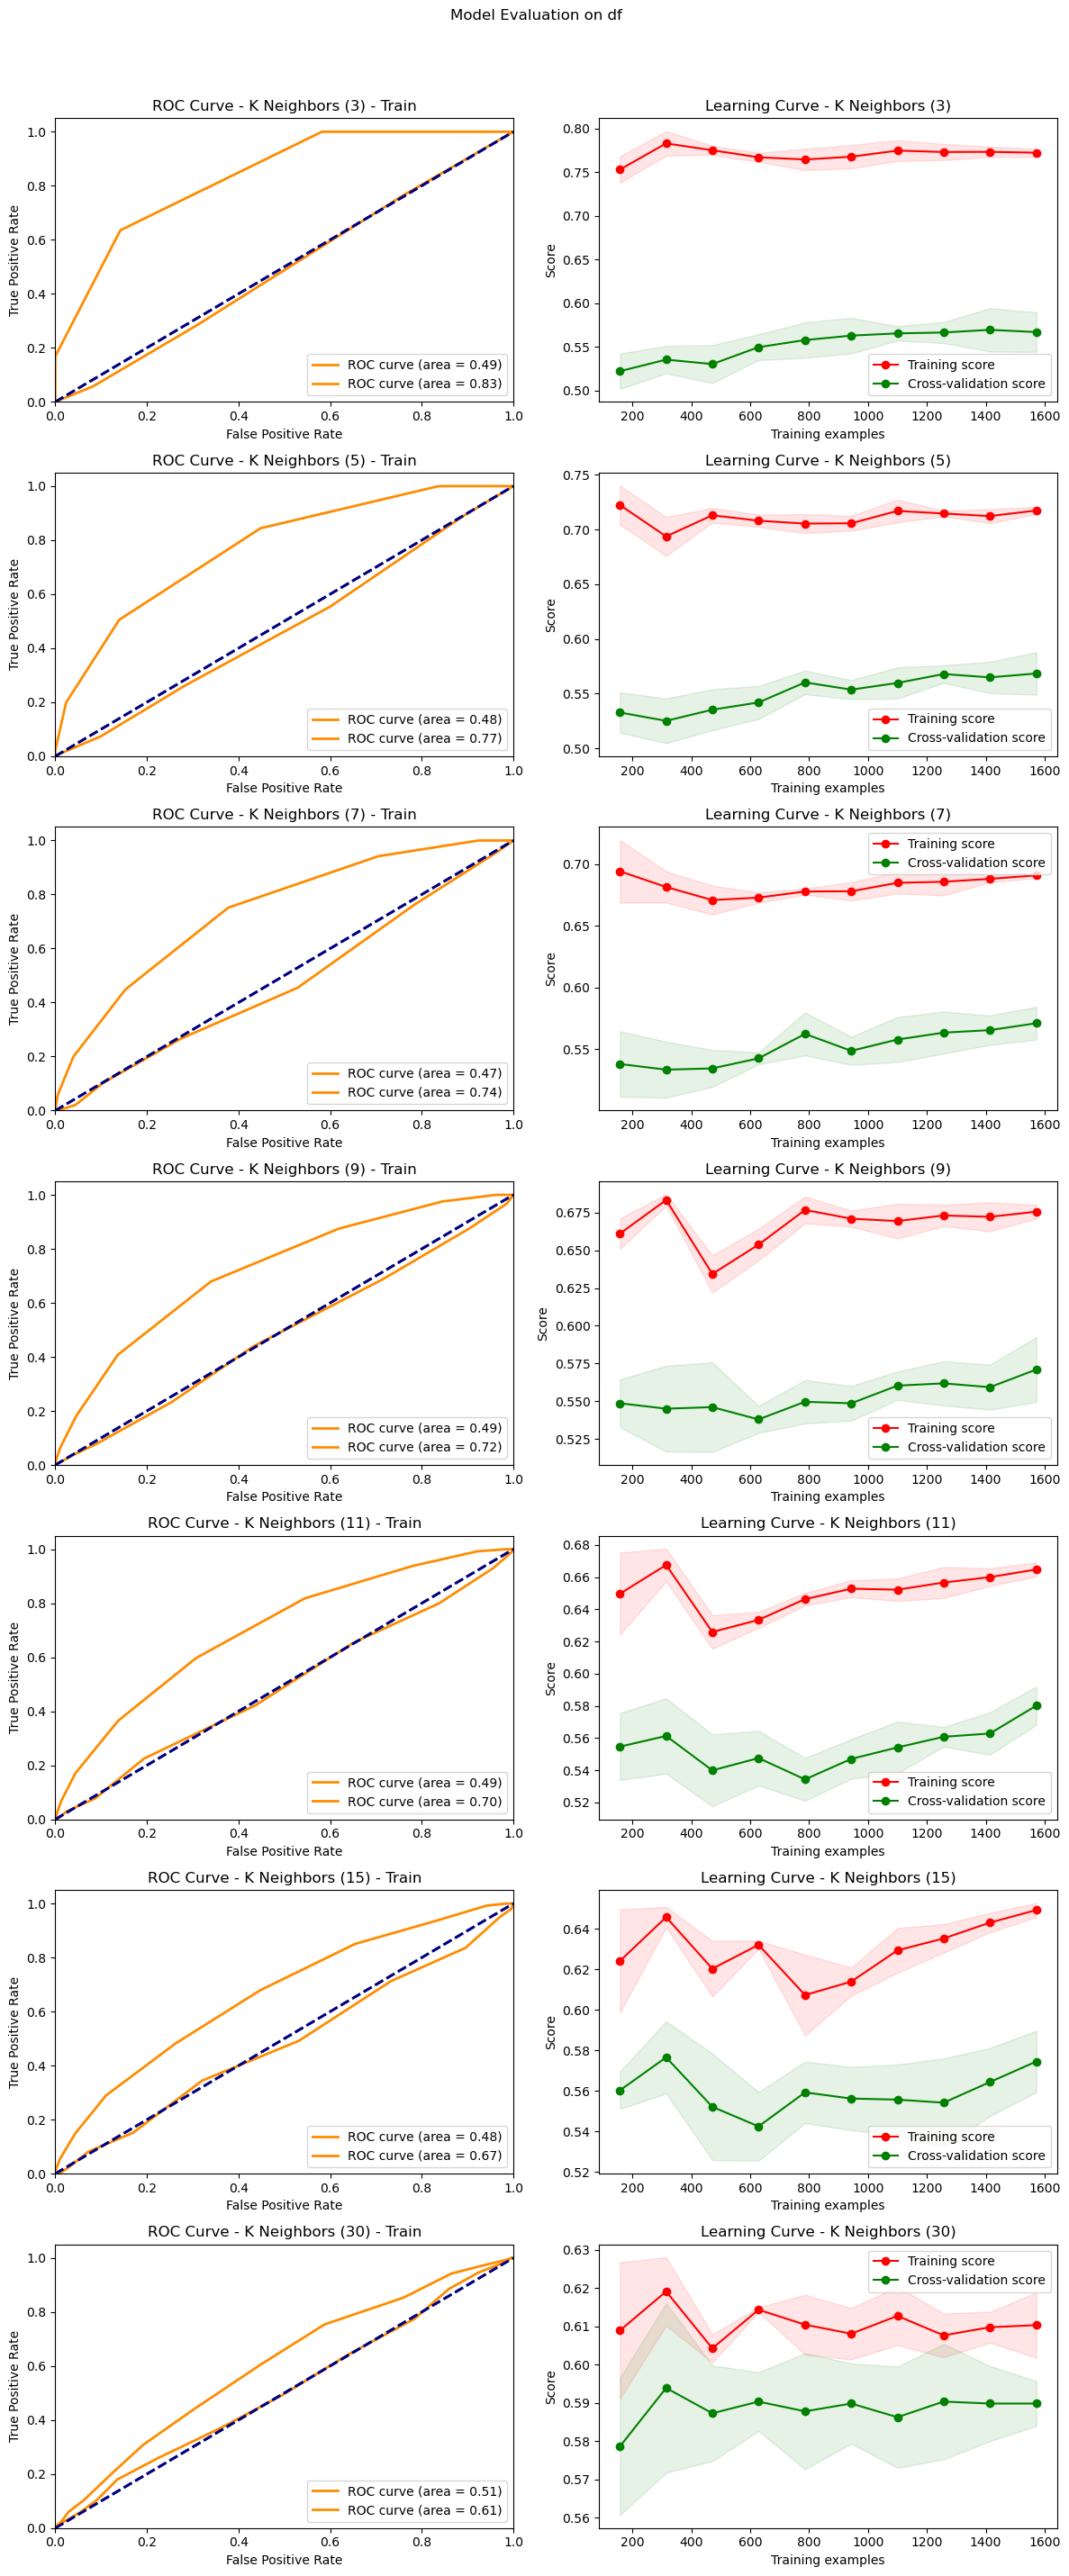

Dataset: df_cleaned
Summary for K Neighbors (3 neighbors) on df_cleaned - Training:
Accuracy: 0.7686
Confusion Matrix:
[[857 136]
 [234 372]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       993
           1       0.73      0.61      0.67       606

    accuracy                           0.77      1599
   macro avg       0.76      0.74      0.75      1599
weighted avg       0.77      0.77      0.76      1599

Summary for K Neighbors (3 neighbors) on df_cleaned - Testing:
Accuracy: 0.5599
Confusion Matrix:
[[232 110]
 [125  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       342
           1       0.38      0.35      0.36       192

    accuracy                           0.56       534
   macro avg       0.51      0.51      0.51       534
weighted avg       0.55      0.56      0.56       534



Dataset: df_cleaned
Summary for K N

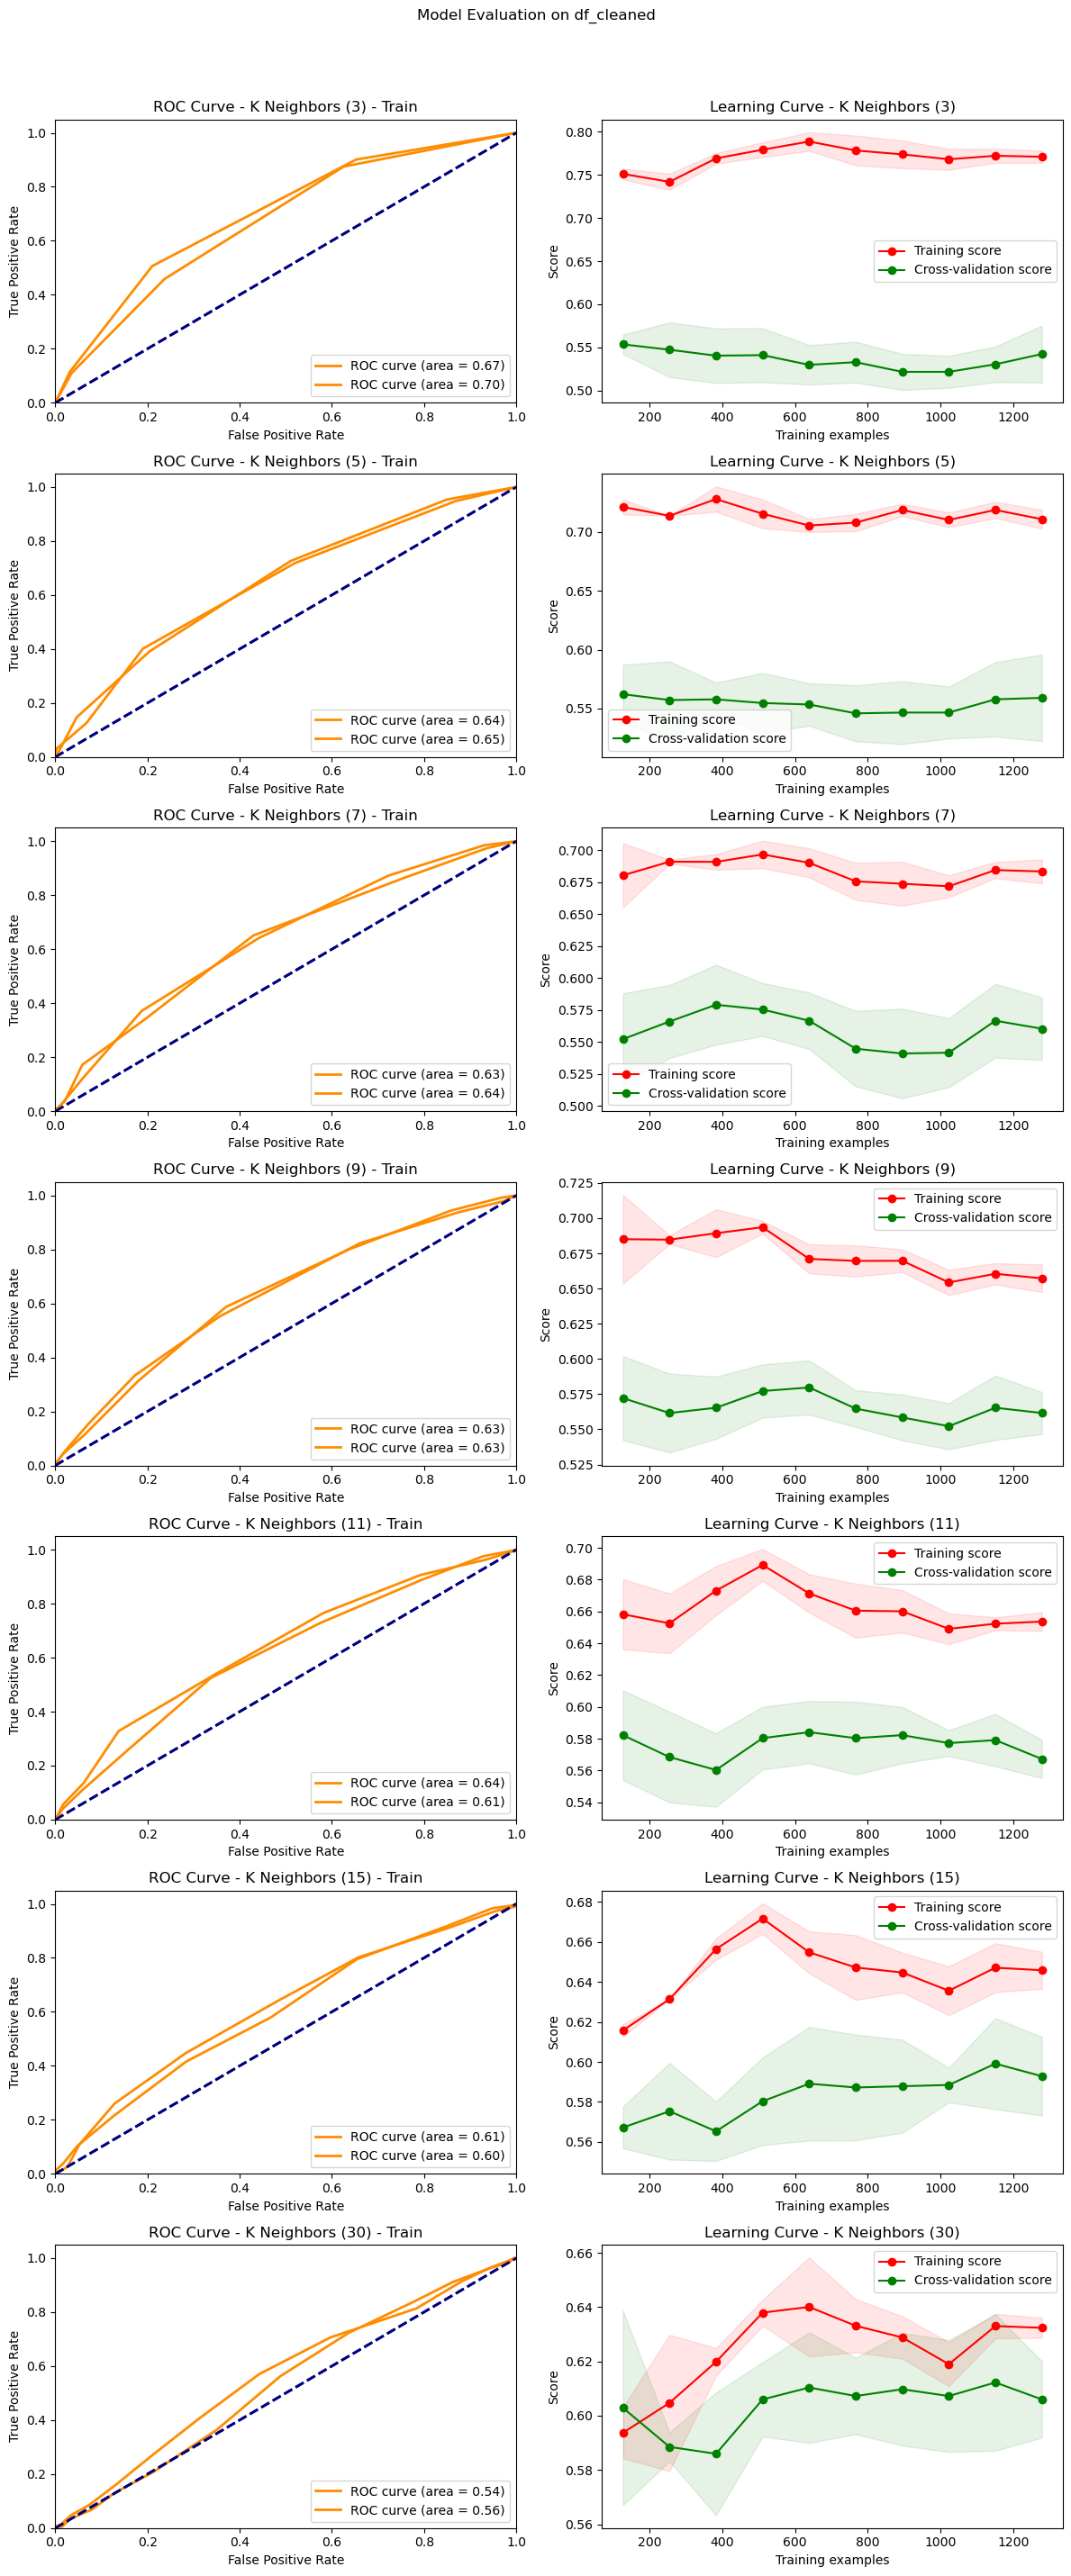

In [44]:
# Function to plot ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, ax, dataset_name):
    model.fit(X_train, y_train)  # Fit the model to the training data
    y_score = model.predict_proba(X_test)[:, 1]  # Predict probabilities on the test set
    fpr, tpr, _ = roc_curve(y_test, y_score)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {dataset_name}')
    ax.legend(loc="lower right")

# Function to plot learning curve for a given model
def plot_learning_curve(model, title, X, y, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.set_title(f"Learning Curve - {title}")
    ax.legend(loc="best")

# Function to generate a summary for a given model
def generate_summary(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, train_predictions)
    accuracy_test = accuracy_score(y_test, test_predictions)

    confusion_mat_train = confusion_matrix(y_train, train_predictions)
    confusion_mat_test = confusion_matrix(y_test, test_predictions)

    classification_rep_train = classification_report(y_train, train_predictions)
    classification_rep_test = classification_report(y_test, test_predictions)

    summary = {
        "Model": model_name,
        "Accuracy_train": accuracy_train,
        "Confusion Matrix_train": confusion_mat_train,
        "Classification Report_train": classification_rep_train,
        "Accuracy_test": accuracy_test,
        "Confusion Matrix_test": confusion_mat_test,
        "Classification Report_test": classification_rep_test,
        "Dataset": dataset_name
    }

    return summary

# Function to evaluate and plot models for a given dataset
def evaluate_and_plot_models(X_train, y_train, X_test, y_test, dataset_name):
    n_neighbors_values = [3, 5, 7, 9, 11, 15, 30]

    all_plots = []  # Store all plots here
    all_summaries = []  # Store summaries for each model

    # Generate summaries for K Neighbors Classifier models
    for n_neighbors_value in n_neighbors_values:
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbors_value)
        summary = generate_summary(knn_model, X_train, y_train, X_test, y_test, model_name=f"K Neighbors ({n_neighbors_value} neighbors)", dataset_name=dataset_name)
        all_summaries.append(summary)

    ## Print summaries
    for summary in all_summaries:
        print(f"Dataset: {summary['Dataset']}")
        print(f"Summary for {summary['Model']} on {summary['Dataset']} - Training:")
        print(f"Accuracy: {summary['Accuracy_train']:.4f}")
        print(f"Confusion Matrix:\n{summary['Confusion Matrix_train']}")
        print(f"Classification Report:\n{summary['Classification Report_train']}")
        print(f"Summary for {summary['Model']} on {summary['Dataset']} - Testing:")
        print(f"Accuracy: {summary['Accuracy_test']:.4f}")
        print(f"Confusion Matrix:\n{summary['Confusion Matrix_test']}")
        print(f"Classification Report:\n{summary['Classification Report_test']}")
        print("\n")

    # Create subplots for ROC Curve and Learning Curve
    fig, axes = plt.subplots(nrows=len(n_neighbors_values), ncols=2, figsize=(12, 4 * len(n_neighbors_values)))
    fig.suptitle(f"Model Evaluation on {dataset_name}", y=1.02)

    row_counter = 0

    ## Plot ROC Curve and Learning Curve for K Neighbors Classifier models
    for n_neighbors_value, summary in zip(n_neighbors_values, all_summaries):
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbors_value)
        plot_roc_curve(knn_model, X_test, y_test, ax=axes[row_counter, 0], dataset_name=f"K Neighbors ({n_neighbors_value}) - Test")
        plot_roc_curve(knn_model, X_train, y_train, ax=axes[row_counter, 0], dataset_name=f"K Neighbors ({n_neighbors_value}) - Train")
        plot_learning_curve(knn_model, f"K Neighbors ({n_neighbors_value})", X_train, y_train, ax=axes[row_counter, 1])
        row_counter += 1

    

    plt.tight_layout()
    plt.show()

# For the 'df' dataset
evaluate_and_plot_models(X_train, y_train, X_test, y_test, dataset_name="df")

# For the 'df_cleaned' dataset
evaluate_and_plot_models(X_cleaned_train, y_cleaned_train, X_cleaned_test, y_cleaned_test, dataset_name="df_cleaned")


Observations:
Overfitting: The models, especially with fewer neighbors, seem to overfit the training data, resulting in a significant drop in performance on the testing set.
Class Imbalance: The models struggle to perform well on the positive class, possibly due to class imbalance.

### Logistic Regression | Random Forest | Naive Bayes models

Dataset: df
Summary for Logistic Regression:
Accuracy: 0.6296
Confusion Matrix:
[[412   0]
 [243   1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       1.00      0.00      0.01       244

    accuracy                           0.63       656
   macro avg       0.81      0.50      0.39       656
weighted avg       0.77      0.63      0.49       656



Dataset: df
Summary for Random Forest:
Accuracy: 0.7988
Confusion Matrix:
[[370  42]
 [ 90 154]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       412
           1       0.79      0.63      0.70       244

    accuracy                           0.80       656
   macro avg       0.80      0.76      0.77       656
weighted avg       0.80      0.80      0.79       656



Dataset: df
Summary for Naive Bayes:
Accuracy: 0.6296
Confusion Matrix:
[[355  57]
 [186  58]]
C

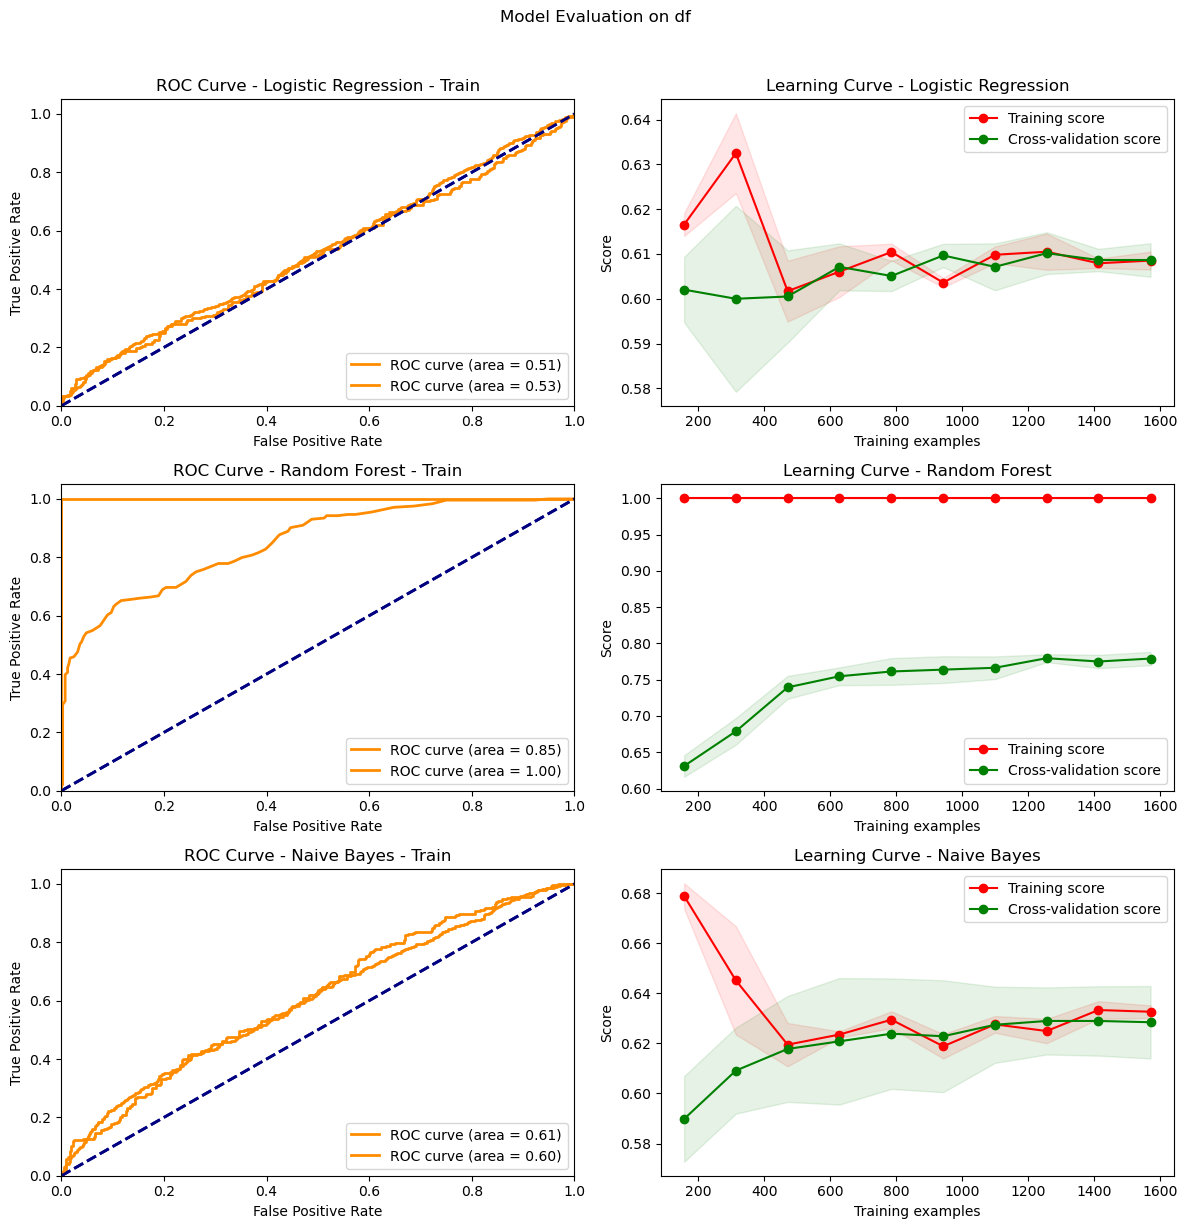

Dataset: df_cleaned
Summary for Logistic Regression:
Accuracy: 0.6404
Confusion Matrix:
[[342   0]
 [192   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       342
           1       0.00      0.00      0.00       192

    accuracy                           0.64       534
   macro avg       0.32      0.50      0.39       534
weighted avg       0.41      0.64      0.50       534



Dataset: df_cleaned
Summary for Random Forest:
Accuracy: 0.7978
Confusion Matrix:
[[319  23]
 [ 85 107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       342
           1       0.82      0.56      0.66       192

    accuracy                           0.80       534
   macro avg       0.81      0.75      0.76       534
weighted avg       0.80      0.80      0.79       534



Dataset: df_cleaned
Summary for Naive Bayes:
Accuracy: 0.6292
Confusion Matrix:


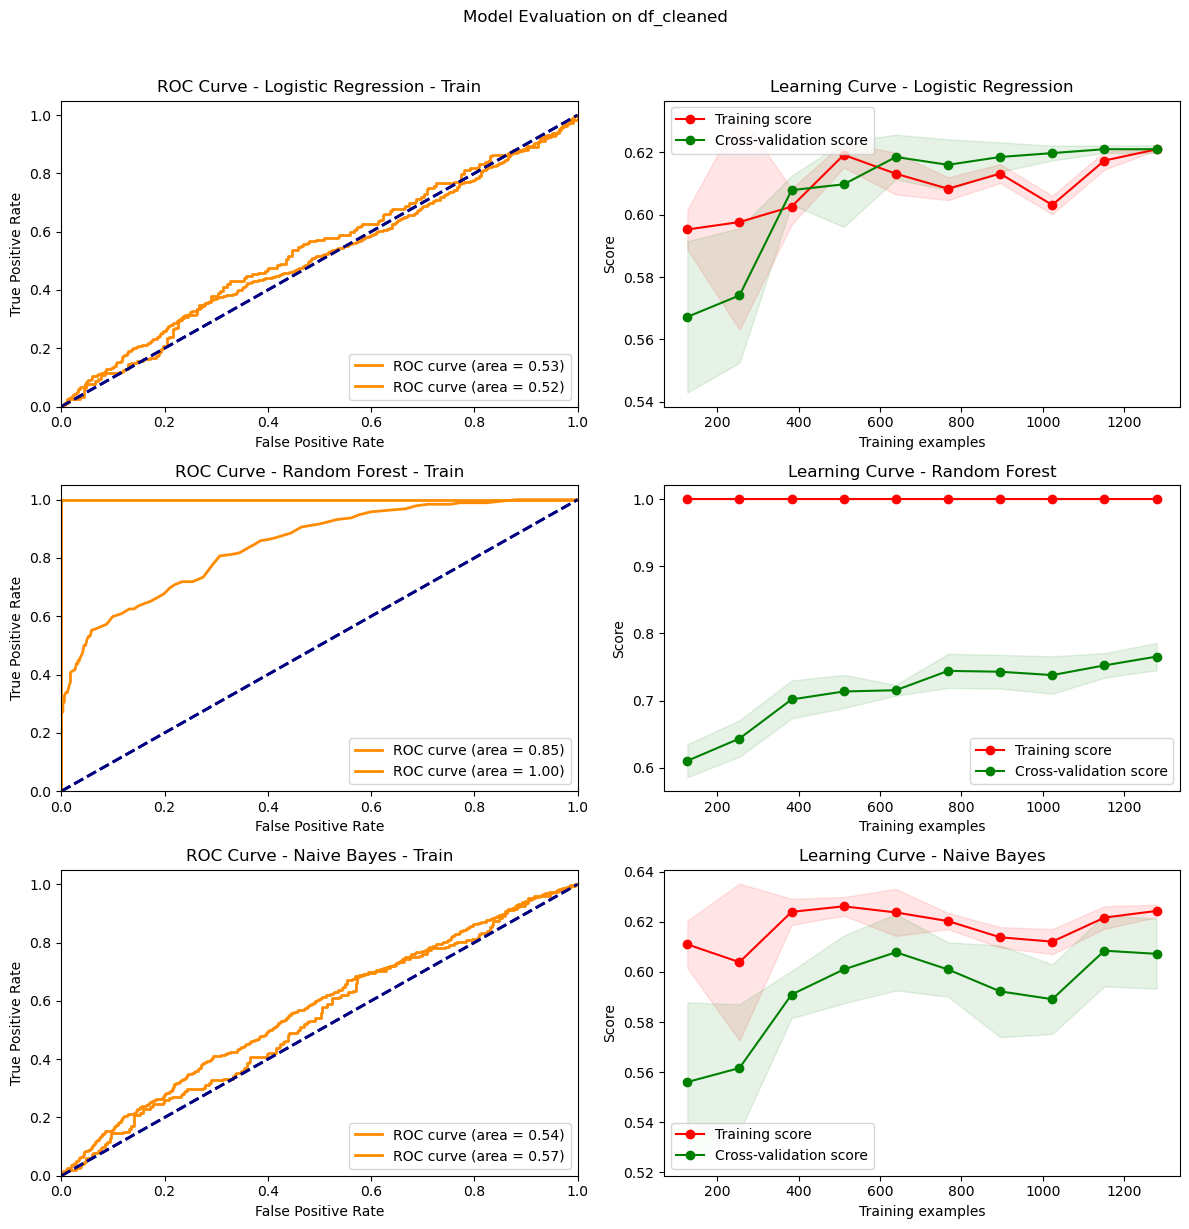

In [45]:
# Function to plot ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, ax, dataset_name):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {dataset_name}')
    ax.legend(loc="lower right")

# Function to plot learning curve for a given model
def plot_learning_curve(model, title, X_train, y_train, X_test, y_test, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.set_title(f"Learning Curve - {title}")
    ax.legend(loc="best")

# Function to generate a summary for a given model
def generate_summary(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    if isinstance(model, LogisticRegression):
        model.set_params(max_iter=1000)

    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, test_predictions)
    confusion_mat = confusion_matrix(y_test, test_predictions)
    classification_rep = classification_report(y_test, test_predictions)

    summary = {
        "Model": model_name,
        "Accuracy": accuracy,
        "Confusion Matrix": confusion_mat,
        "Classification Report": classification_rep,
        "Dataset": dataset_name
    }

    return summary

# Function to evaluate and plot models for a given dataset
def evaluate_and_plot_models(X_train, y_train, X_test, y_test, dataset_name):
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "Naive Bayes": GaussianNB(),
    }

    all_summaries = []  # Store summaries for each model

    # Generate summaries for each model
    for model_name, model in models.items():
        summary = generate_summary(model, X_train, y_train, X_test, y_test, model_name=model_name, dataset_name=dataset_name)
        all_summaries.append(summary)

    # Print summaries
    for summary in all_summaries:
        print(f"Dataset: {summary['Dataset']}")
        print(f"Summary for {summary['Model']}:")
        print(f"Accuracy: {summary['Accuracy']:.4f}")
        print(f"Confusion Matrix:\n{summary['Confusion Matrix']}")
        print(f"Classification Report:\n{summary['Classification Report']}")
        print("\n")

    # Create subplots for ROC Curve and Learning Curve
    fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(12, 4 * len(models)))
    fig.suptitle(f"Model Evaluation on {dataset_name}", y=1.02)

    row_counter = 0

    # Plot ROC Curve and Learning Curve for each model
    for model_name, model, summary in zip(models.keys(), models.values(), all_summaries):
        plot_roc_curve(model, X_test, y_test, ax=axes[row_counter, 0], dataset_name=model_name + " - Test")
        plot_roc_curve(model, X_train, y_train, ax=axes[row_counter, 0], dataset_name=model_name + " - Train")
        plot_learning_curve(model, model_name, X_train, y_train, X_test, y_test, ax=axes[row_counter, 1])
        row_counter += 1

    plt.tight_layout()
    plt.show()

# Sample data - adjust to your data
# Assuming X_train_df, y_train_df, X_test_df, y_test_df, X_train_cleaned, y_train_cleaned, X_test_cleaned, y_test_cleaned are available

# For the 'df' dataset
evaluate_and_plot_models(X_train, y_train, X_test, y_test, dataset_name="df")

# For the 'df_cleaned' dataset
evaluate_and_plot_models(X_cleaned_train, y_cleaned_train, X_cleaned_test, y_cleaned_test, dataset_name="df_cleaned")


Observations:
The Random Forest model tends to overfit the training data, as evidenced by its perfect accuracy on the training datasets but lower accuracy on the testing datasets.
Logistic Regression and Naive Bayes exhibit more stable performance but struggle to predict the positive class, especially on the original data.
The models trained on the cleaned dataset do not consistently outperform their counterparts trained on the original data.
Naive Bayes, the accuracy on the training dataset is 63.16%, indicating moderate performance. The performance on the testing dataset is consistent with the training dataset, with an accuracy of 62.96%.


CV=2, Best Hyperparameters: {'eta': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 25, 'subsample': 0.7}
CV=2, Mean Accuracy on Training Set (df): 0.7821892746963139
CV=2, Mean Accuracy on Test Set (df): 0.698170731707317


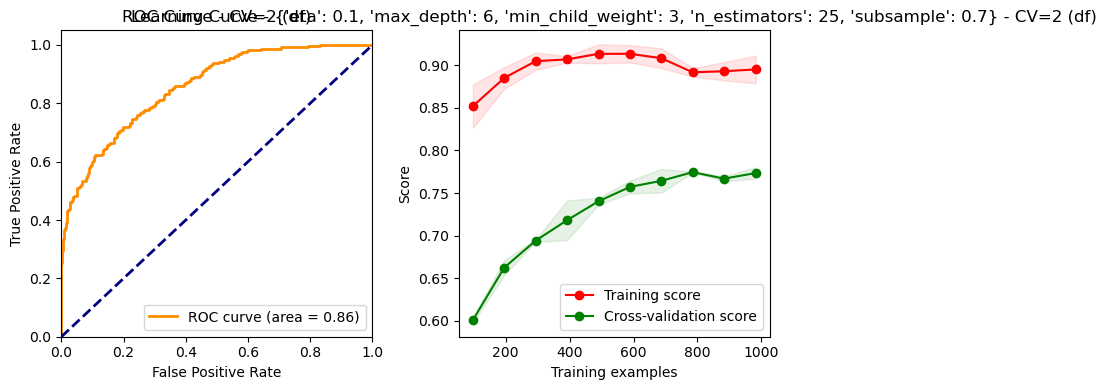

CV=3, Best Hyperparameters: {'eta': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 25, 'subsample': 0.7}
CV=3, Mean Accuracy on Training Set (df): 0.7944020356234097
CV=3, Mean Accuracy on Test Set (df): 0.7073017468895312


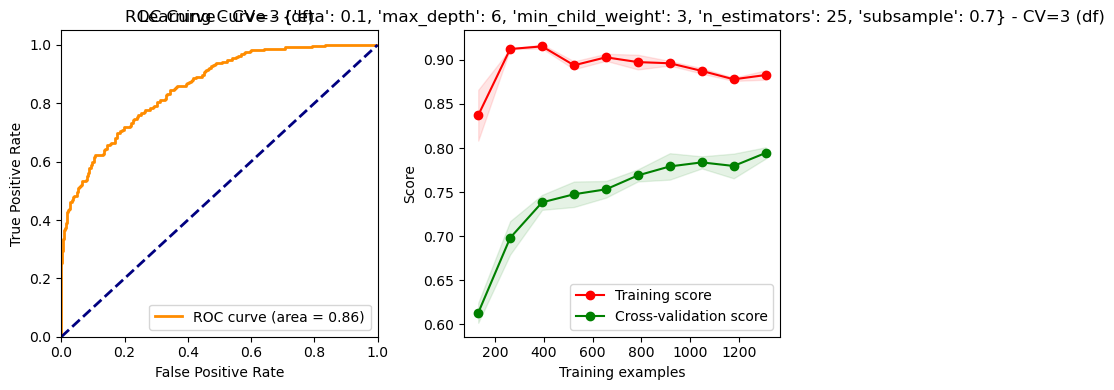

CV=4, Best Hyperparameters: {'eta': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}
CV=4, Mean Accuracy on Training Set (df): 0.7918550163098372
CV=4, Mean Accuracy on Test Set (df): 0.7164634146341463


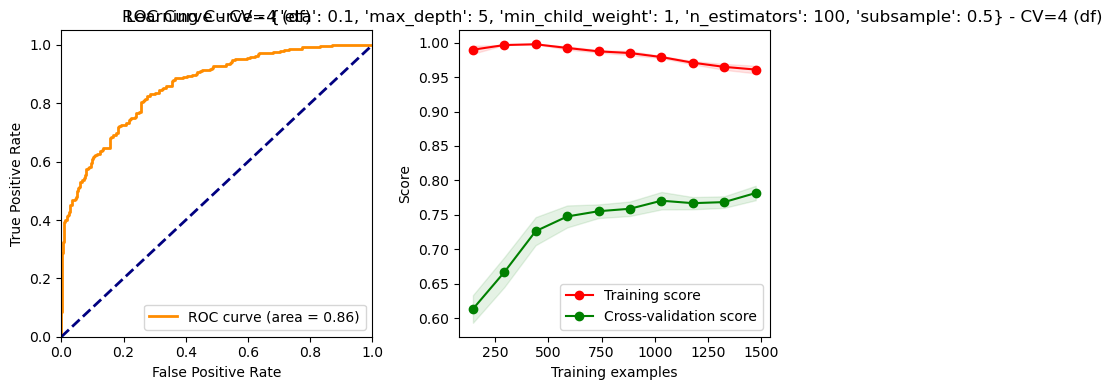

CV=5, Best Hyperparameters: {'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 25, 'subsample': 0.7}
CV=5, Mean Accuracy on Training Set (df): 0.7862595419847328
CV=5, Mean Accuracy on Test Set (df): 0.737855655794587


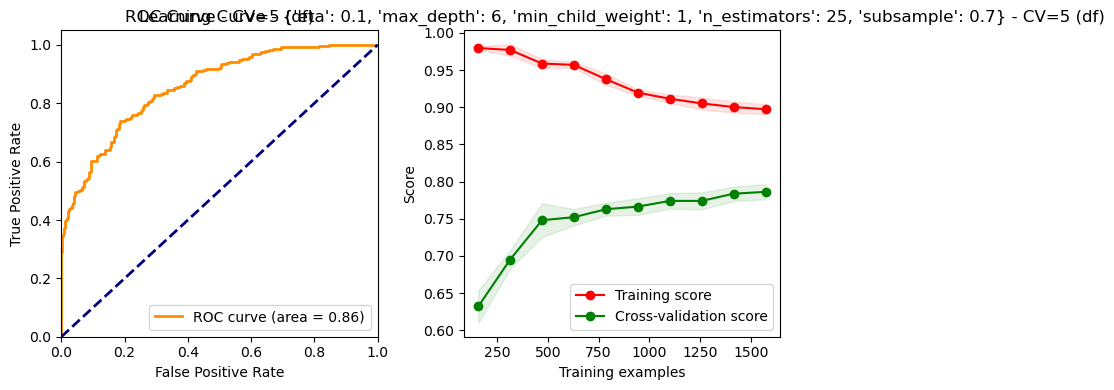

CV=2, Best Hyperparameters: {'eta': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 25, 'subsample': 0.7}
CV=2, Mean Accuracy on Training Set (df_cleaned): 0.7723631101376721
CV=2, Mean Accuracy on Test Set (df_cleaned): 0.6853932584269662


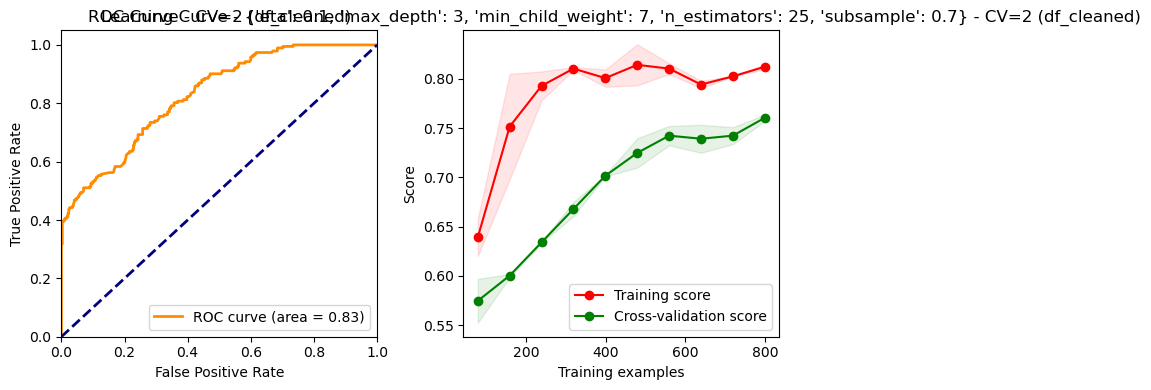

CV=3, Best Hyperparameters: {'eta': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 25, 'subsample': 0.7}
CV=3, Mean Accuracy on Training Set (df_cleaned): 0.7786116322701689
CV=3, Mean Accuracy on Test Set (df_cleaned): 0.745318352059925


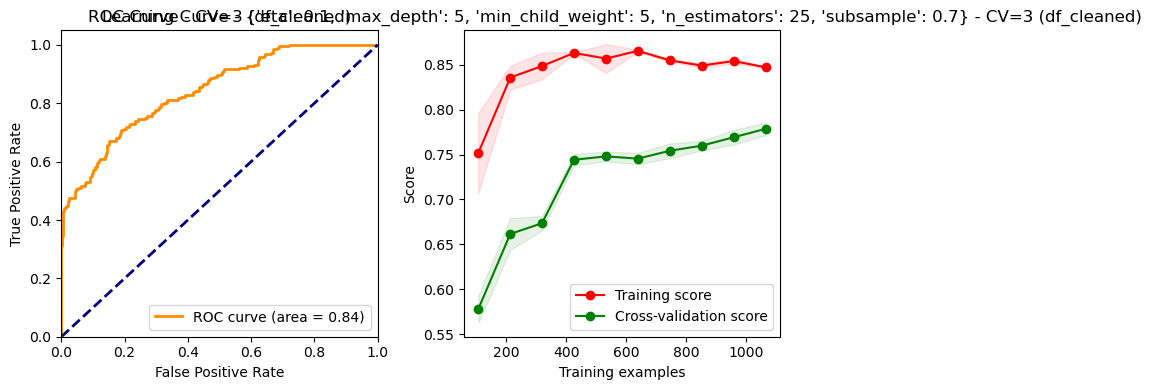

CV=4, Best Hyperparameters: {'eta': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}
CV=4, Mean Accuracy on Training Set (df_cleaned): 0.7855028195488722
CV=4, Mean Accuracy on Test Set (df_cleaned): 0.7340926944226238


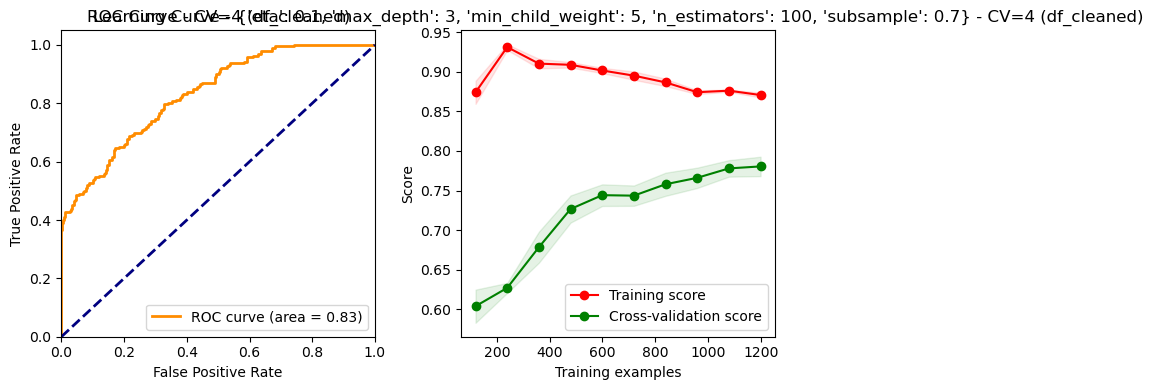

CV=5, Best Hyperparameters: {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 25, 'subsample': 0.7}
CV=5, Mean Accuracy on Training Set (df_cleaned): 0.7817496081504702
CV=5, Mean Accuracy on Test Set (df_cleaned): 0.7265208957855757


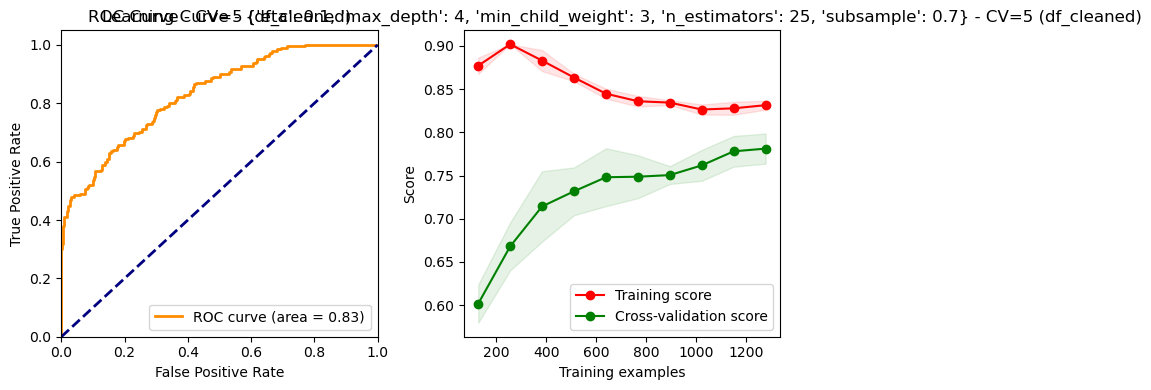

In [46]:
def evaluate_model_cv(X_train, y_train, X_test, y_test, hyperparameters, cv_values, dataset_name):
    for cv in cv_values:
        # Przeszukiwanie siatki
        model = XGBClassifier()
        grid_search = GridSearchCV(model, hyperparameters, cv=cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Najlepsze znalezione hiperparametry
        best_params = grid_search.best_params_
        print(f'CV={cv}, Best Hyperparameters: {best_params}')

        # Ewaluacja modelu z najlepszymi hiperparametrami za pomocą cross_val_score
        model_with_best_params = XGBClassifier(**best_params)

        # Walidacja krzyżowa dla danych treningowych
        scores_train = cross_val_score(model_with_best_params, X_train, y_train, cv=cv, scoring='accuracy')
        mean_accuracy_train = scores_train.mean()

        # Walidacja krzyżowa dla danych testowych
        scores_test = cross_val_score(model_with_best_params, X_test, y_test, cv=cv, scoring='accuracy')
        mean_accuracy_test = scores_test.mean()

        # Wyświetlenie wyników Accuracy
        print(f'CV={cv}, Mean Accuracy on Training Set ({dataset_name}): {mean_accuracy_train}')
        print(f'CV={cv}, Mean Accuracy on Test Set ({dataset_name}): {mean_accuracy_test}')

        # Wykres ROC Curve dla danych testowych
        model_with_best_params.fit(X_train, y_train)
        y_score = model_with_best_params.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - CV={cv} ({dataset_name})')
        plt.legend(loc="lower right")

        # Wykres Learning Curve dla danych treningowych
        skf = StratifiedKFold(n_splits=cv)
        train_sizes, train_scores, test_scores = learning_curve(
            model_with_best_params, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.subplot(1, 2, 2)
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.title(f"Learning Curve - {best_params} - CV={cv} ({dataset_name})")
        plt.legend(loc="best")

        plt.tight_layout()
        plt.show()

# Przykład użycia
hyperparameters = {
    'eta': [0.01, 0.1, 0.2, 0.5, 1],
    'n_estimators': [15, 25, 50, 75, 100],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.2, 0.5, 0.7]
}

# X_train, y_train to dane treningowe, X_test, y_test to dane testowe
evaluate_model_cv(X_train, y_train, X_test, y_test, hyperparameters, cv_values=[2, 3, 4, 5], dataset_name="df")

# X_cleaned_train, y_cleaned_train to dane treningowe, X_cleaned_test, y_cleaned_test to dane testowe
evaluate_model_cv(X_cleaned_train, y_cleaned_train, X_cleaned_test, y_cleaned_test, hyperparameters, cv_values=[2, 3, 4, 5], dataset_name="df_cleaned")


### Checking the model's performance on the validation dataset

Dataset: df
Summary for XGBoost on df:
Model: XGBoost
Accuracy_train: 0.8422391857506362
Confusion Matrix_train: [[1108   81]
 [ 229  547]]
Classification Report_train:               precision    recall  f1-score   support

           0       0.83      0.93      0.88      1189
           1       0.87      0.70      0.78       776

    accuracy                           0.84      1965
   macro avg       0.85      0.82      0.83      1965
weighted avg       0.85      0.84      0.84      1965

Accuracy_test: 0.7877862595419848
Confusion Matrix_test: [[355  42]
 [ 97 161]]
Classification Report_test:               precision    recall  f1-score   support

           0       0.79      0.89      0.84       397
           1       0.79      0.62      0.70       258

    accuracy                           0.79       655
   macro avg       0.79      0.76      0.77       655
weighted avg       0.79      0.79      0.78       655

Dataset: df


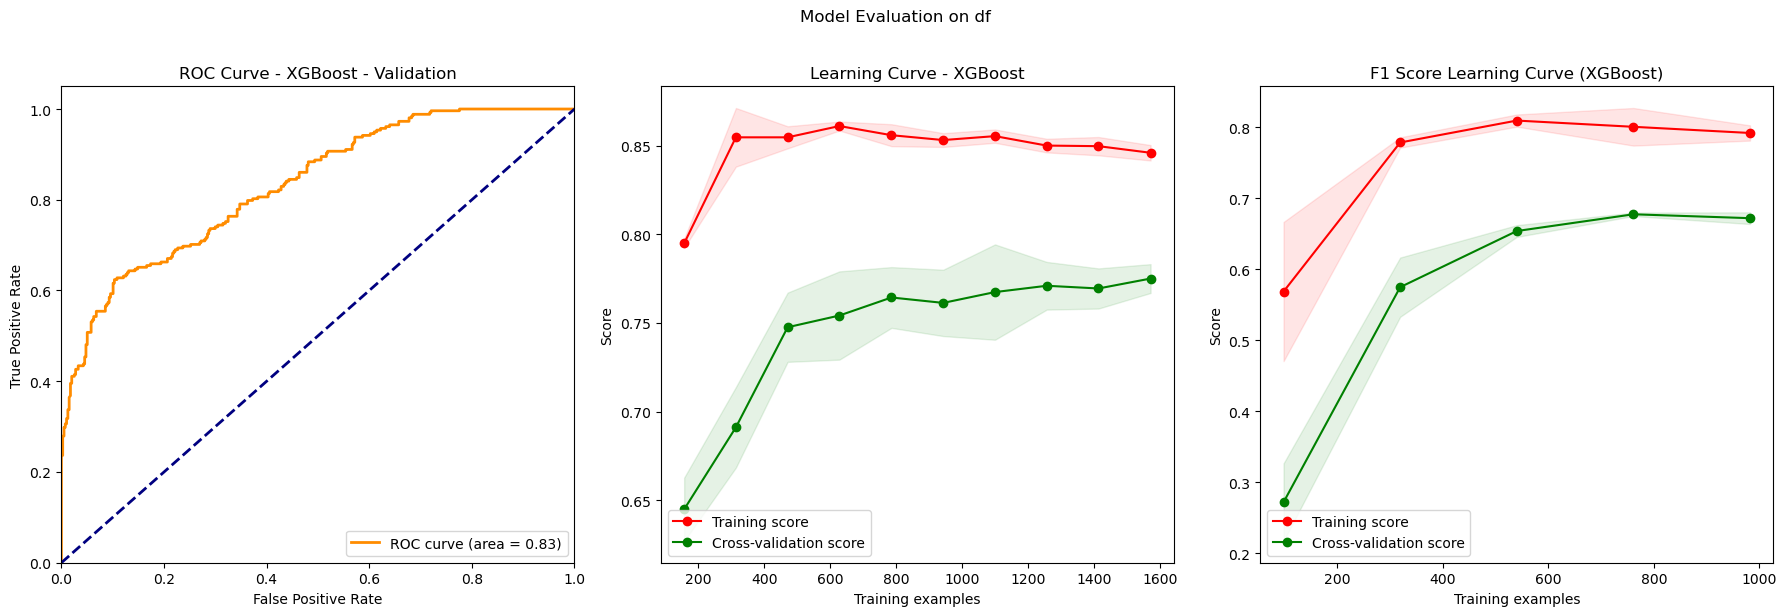

In [47]:
# Function to plot ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, ax, dataset_name):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {dataset_name}')
    ax.legend(loc="lower right")

# Function to plot learning curve for a given model
def plot_learning_curve(model, title, X_train, y_train, X_test, y_test, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.set_title(f"Learning Curve - {title}")
    ax.legend(loc="best")

# Funkcja do generowania podsumowania dla danego modelu
def generate_summary(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, train_predictions)
    accuracy_test = accuracy_score(y_test, test_predictions)

    confusion_mat_train = confusion_matrix(y_train, train_predictions)
    confusion_mat_test = confusion_matrix(y_test, test_predictions)

    classification_rep_train = classification_report(y_train, train_predictions)
    classification_rep_test = classification_report(y_test, test_predictions)

    summary = {
        "Model": model_name,
        "Accuracy_train": accuracy_train,
        "Confusion Matrix_train": confusion_mat_train,
        "Classification Report_train": classification_rep_train,
        "Accuracy_test": accuracy_test,
        "Confusion Matrix_test": confusion_mat_test,
        "Classification Report_test": classification_rep_test,
        "Dataset": dataset_name
    }

    return summary

# Funkcja do rysowania krzywej F1 Score
def plot_f1_curve(model, X_train, y_train, X_test, y_test, ax, dataset_name):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=2, scoring='f1', n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_title(f"F1 Score Learning Curve ({dataset_name})")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

# Zapisane XGBoost hyperparameters
xgb_hyperparameters = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 25,
    'subsample': 0.7,
    'objective': 'binary:logistic',
    'use_label_encoder': False
}

# Utwórz XGBoost model z zapisanymi hyperparameters
xgb_model = XGBClassifier(**xgb_hyperparameters)

# Wywołaj funkcję generate_summary do uzyskania podsumowania modelu
summary = generate_summary(xgb_model, X_train, y_train, X_val, y_val, model_name="XGBoost", dataset_name="df")

# Wyświetl podsumowanie
print(f"Dataset: {summary['Dataset']}")
print(f"Summary for {summary['Model']} on {summary['Dataset']}:")

# Wyświetl wszystkie dostępne klucze w słowniku podsumowania
for key, value in summary.items():
    print(f"{key}: {value}")

# Utwórz subploty dla krzywej ROC, krzywej uczenia i krzywej F1 Score
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle(f"Model Evaluation on {summary['Dataset']}", y=1.02)

# Narysuj krzywą ROC, krzywą uczenia i krzywą F1 Score dla modelu XGBoost
plot_roc_curve(xgb_model, X_val, y_val, ax=axes[0], dataset_name="XGBoost - Validation")
plot_learning_curve(xgb_model, "XGBoost", X_train, y_train, X_val, y_val, ax=axes[1])
plot_f1_curve(xgb_model, X_train, y_train, X_val, y_val, ax=axes[2], dataset_name="XGBoost")

plt.tight_layout()
plt.show()


### Relevance of features in the selected model XGBClassifier

           Feature  Importance
4          sulfate    0.230264
0               ph    0.215010
2           solids    0.104961
1         hardness    0.101244
3      chloramines    0.084228
8        turbidity    0.071489
7  trihalomethanes    0.068353
5     conductivity    0.066870
6   organic_carbon    0.057581


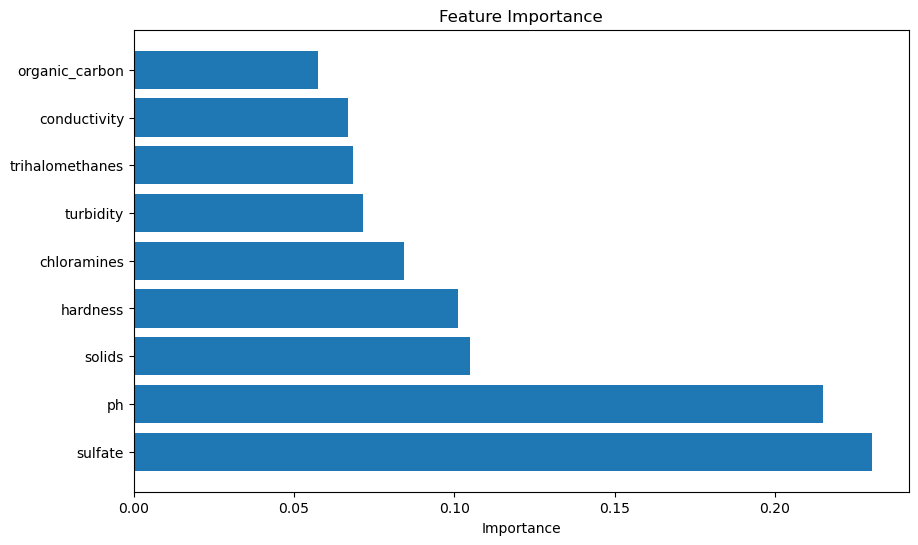

In [48]:
feature_names = ['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity']

def plot_feature_importance(xgb_model, feature_names):
    # Obtaining feature importances from the XGBoost model
    feature_importance = xgb_model.feature_importances_

    # Creating a DataFrame with feature names and their importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Displaying the feature importances
    print(feature_importance_df)

    # Plotting feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(xgb_model, feature_names)


In [49]:
df.iloc[2070].drop(df.columns[-1]).to_dict()

{'ph': 6.2106476062546205,
 'hardness': 192.21673841027888,
 'solids': 19330.035764975924,
 'chloramines': 8.79288608641629,
 'sulfate': 328.42152030520873,
 'conductivity': 401.3832641880552,
 'organic_carbon': 18.22549226740699,
 'trihalomethanes': 61.27421598577666,
 'turbidity': 3.212123979887552}

In [50]:
# Zapisane XGBoost hyperparameters
xgb_hyperparameters = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 25,
    'subsample': 0.7,
    'objective': 'binary:logistic',
    'use_label_encoder': False
}

# Utwórz XGBoost model z zapisanymi hyperparameters
xgb_model = XGBClassifier(**xgb_hyperparameters)

# Dopasuj model do danych treningowych
xgb_model.fit(X_cleaned_train, y_cleaned_train)

# Dokonaj predykcji na zbiorze walidacyjnym
val_predictions = xgb_model.predict(X_cleaned_val)

# Uzyskaj miary jakości modelu
accuracy_val = accuracy_score(y_cleaned_val, val_predictions)
confusion_mat_val = confusion_matrix(y_cleaned_val, val_predictions)
classification_rep_val = classification_report(y_cleaned_val, val_predictions)

# Wyświetl podsumowanie
print("Summary for XGBoost on df_cleaned - Validation:")
print(f"Accuracy: {accuracy_val}")
print("Confusion Matrix:")
print(confusion_mat_val)
print("Classification Report:")
print(classification_rep_val)

Summary for XGBoost on df_cleaned - Validation:
Accuracy: 0.7804878048780488
Confusion Matrix:
[[310  26]
 [ 91 106]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       336
           1       0.80      0.54      0.64       197

    accuracy                           0.78       533
   macro avg       0.79      0.73      0.74       533
weighted avg       0.78      0.78      0.77       533



## Using model

In [51]:
water_data = [7.481397771916631,186.07476549927424,13781.780283955726,4.649253929836745,377.3443718640398,323.7728426252204,11.687123837165814,66.2916498377711,4.039976289796705]

In [52]:
water_data = {'ph': 8.550525459441477,
 'hardness': 209.682466228215,
 'solids': 22377.2729499167,
 'chloramines': 2.654490953924924,
 'sulfate': 322.15603714649086,
 'conductivity': 413.6735860767769,
 'organic_carbon': 12.99676072996226,
 'trihalomethanes': 42.989849180469655,
 'turbidity': 4.591997454258289}

In [53]:
water_data = {'ph': 8.016279103360878,
 'hardness': 211.0293038198348,
 'solids': 14034.485798658789,
 'chloramines': 9.796999515077292,
 'sulfate': 389.3387958191684,
 'conductivity': 491.0790820972671,
 'organic_carbon': 14.51299105109308,
 'trihalomethanes': 35.56596645086621,
 'turbidity': 4.308222881195557}

In [54]:
def predict_water_potability(model, input_data, true_labels=None, class_labels=None):
    # Check if input_data is a list, dict, DataFrame, or numpy array
    if isinstance(input_data, list):
        # Assuming each element in the list corresponds to a feature in the order defined by feature_names
        input_data_dict = dict(zip(feature_names, input_data))
        input_array = pd.DataFrame([input_data_dict], columns=feature_names).values
    elif isinstance(input_data, dict):
        # Convert the dictionary to a DataFrame and then to a 2D NumPy array
        input_array = pd.DataFrame([input_data], columns=feature_names).values
    elif isinstance(input_data, pd.DataFrame):
        # Convert the DataFrame to a 2D NumPy array
        input_array = input_data.values
    elif isinstance(input_data, np.ndarray):
        # Check if the array is 1D, and if so, reshape it to 2D
        input_array = input_data.reshape(1, -1) if len(input_data.shape) == 1 else input_data
    else:
        # If format not supported, raise an error
        raise ValueError("Unsupported input data format. Supported formats: list, dict, DataFrame, numpy array.")

    # Make predictions
    predictions = model.predict(input_array)
    probability = model.predict_proba(input_array)[:, 1]
    print(f"Probability for class 1: {probability[0] * 100:.2f}%")

    # Print predictions with class labels if provided
    if class_labels:
        for prediction in predictions:
            if 0 <= prediction < len(class_labels):
                print(f"Predicted water quality: '{class_labels[int(prediction)]}'")
            else:
                print("Invalid water quality prediction")

    # Print accuracy if true_labels are provided
    if true_labels is not None:
        accuracy = accuracy_score(true_labels, predictions)
        print(f"Model accuracy: {accuracy * 100:.2f}%")

    return predictions



# Define water quality labels
water_potability_labels = ["undrinkable", "drinkable"]

# Assuming `water_data` is a dictionary and `true_labels` is available

true_labels = [1]  # Replace with your true labels
predictions = predict_water_potability(xgb_model, water_data, true_labels=true_labels, class_labels=water_potability_labels)


Probability for class 1: 44.93%
Predicted water quality: 'undrinkable'
Model accuracy: 0.00%


Save the mode

In [55]:
import pickle
import os

In [56]:
output_file = f"model_wpp.pkl"

In [57]:
output_file

'model_wpp.pkl'

In [58]:
f_out = open(output_file, "wb")
pickle.dump(xgb_model, f_out)
f_out.close()

In [59]:
!ls -lh *.pkl

-rw-rw-r-- 1 adam adam 65K gru 19 20:04 model_mpp.pkl
-rw-rw-r-- 1 adam adam 47K gru 19 20:55 model_wpp.pkl


In [60]:
# Get the full path to the saved file
output_filepath = os.path.abspath(output_file)

# Display the saved model's name and its full path
print(f"Saved the model as: {output_file}")
print(f"Full path to the saved model: {output_filepath}")

Saved the model as: model_wpp.pkl
Full path to the saved model: /home/adam/anaconda3/envs/c_wpp/Capstone_project_1/model_wpp.pkl


In [61]:
with open(output_file, "wb") as f_out:
    pickle.dump(xgb_model, f_out)

In [62]:
display(df.iloc[2566].drop(df.columns[-1]).to_dict()) #0
display(df.iloc[1200].drop(df.columns[-1]).to_dict()) #1

{'ph': 8.550525459441477,
 'hardness': 209.682466228215,
 'solids': 22377.2729499167,
 'chloramines': 2.654490953924924,
 'sulfate': 322.15603714649086,
 'conductivity': 413.6735860767769,
 'organic_carbon': 12.99676072996226,
 'trihalomethanes': 42.989849180469655,
 'turbidity': 4.591997454258289}

{'ph': 8.016279103360878,
 'hardness': 211.0293038198348,
 'solids': 14034.485798658789,
 'chloramines': 9.796999515077292,
 'sulfate': 389.3387958191684,
 'conductivity': 491.0790820972671,
 'organic_carbon': 14.51299105109308,
 'trihalomethanes': 35.56596645086621,
 'turbidity': 4.308222881195557}

Load the model

In [1]:
import pickle

In [2]:
input_file = "model_wpp.pkl"

In [3]:
with open(input_file, "rb") as f_in:
    model = pickle.load(f_in)

In [4]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Test the model

In [5]:
import requests

In [6]:
url = "http://localhost:9696/predict"

In [7]:
water_data = [7.481397771916631,186.07476549927424,13781.780283955726,4.649253929836745,377.3443718640398,323.7728426252204,11.687123837165814,66.2916498377711,4.039976289796705]

In [11]:
water_data = {'ph': 8.550525459441477,
 'hardness': 209.682466228215,
 'solids': 22377.2729499167,
 'chloramines': 2.654490953924924,
 'sulfate': 322.15603714649086,
 'conductivity': 413.6735860767769,
 'organic_carbon': 12.99676072996226,
 'trihalomethanes': 42.989849180469655,
 'turbidity': 4.591997454258289}

In [12]:
response = requests.post(url, json=water_data).json()

In [13]:
response

{'water_quality': 'drinkable'}